# Analysis

This is a loaded notebook that:
* Attempts to identify backtracking neurons in the model.
* Validates the identified neurons on a new dataset.
* Visualizes the activations of the identified neurons.
* Analyzes the backtracking loss of the identified neurons.
* Visualizes the backtracking loss of the identified neurons.
* Visualizes attention patterns on CoTs.
* Prints results and analysis to the console.

In [1]:

from transformer_lens import HookedTransformer
import torch
import circuitsvis as cv
import einops
from IPython.display import Image, display
import numpy as np
from pprint import pprint
from datasets import load_dataset
import random
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from scipy.stats import hypergeom
import os
import re
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
import pandas as pd
from collections import Counter
from utils import *

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-03-01 17:37:27.729738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740850647.748654  518641 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740850647.754337  518641 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register facto

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print('Got device:', device)

Got device: cuda


Disable gradient computation for all tensors to speed up inference and save memory.

In [3]:
torch.set_grad_enabled(False)

In [4]:
model = HookedTransformer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
model = model.to(device)
model.cfg.n_ctx = 2048

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer
Moving model to device:  cuda


For some of the experiments, we need a flagship example to showcase backtracking (as we can't visualize all neurons and activations for ALL examples).

In [5]:
with open("backtracking_dataset_n=1000.json", "r") as f: examples = json.load(f)
examples = [x for x in examples if x["has_backtracking"] and x["is_correct"] and "i think i made a mistake" in x["generated_cot"].lower()]
examples.sort(key=lambda x: len(x["generated_cot"]))
example = examples[0]["generated_cot"]
pprint(example[0: 512])

('Solve this math problem step by step. Put your final answer in \\boxed{}. '
 'Problem: Simplify\n'
 '\\[\\left( \\frac{1 + i}{1 - i} \\right)^{1000}.\\] Solution: \n'
 '<think>\n'
 'Alright, so I have this math problem to solve: Simplify \\(\\left( \\frac{1 '
 "+ i}{1 - i} \\right)^{1000}\\). Hmm, okay. Let's see how to approach this.\n"
 '\n'
 'First off, I remember that \\(i\\) is the imaginary unit, defined by \\(i^2 '
 '= -1\\). So, any expression involving \\(i\\) can be simplified using this '
 'property. But before that, I also recall that complex numbers c')


In [17]:
analysis = run_analysis("math_cot_results_t=0.6_mnt=1500_tp=0.92.json")
# analysis = run_analysis("math_cot_results_t=0.7_mnt=1800_tp=0.92.json")
# analysis = run_analysis("math_cot_results_t=0.8_mnt=3600_tp=0.92.json")

Analyzing 996 CoT solutions...

CHAIN-OF-THOUGHT ANALYSIS REPORT

Total problems analyzed: 996

1. CORRECTNESS
Correct answers: 359 (36.04%)

2. THINK TAGS
Solutions with </think> close tags: 536 (53.82%)

3. TOKEN LIMITS
Problems that ran out of tokens: 533 (53.51%)

4. BACKTRACKING
Solutions with backtracking: 839 (84.24%)
Sample of problems with backtracking:
     Level: Level 2, Type: Algebra, Phrases: Wait, wait, let me double-check
     Level: Level 5, Type: Prealgebra, Phrases: Wait
     Level: Level 1, Type: Counting & Probability, Phrases: Wait
     Level: Level 1, Type: Algebra, Phrases: Wait
     Level: Level 3, Type: Counting & Probability, Phrases: Wait, wait, let me double-check
     Level: Level 3, Type: Intermediate Algebra, Phrases: Wait, wait, let me double-check
     Level: Level 3, Type: Algebra, Phrases: Wait, wait, let me double-check
     Level: Level 1, Type: Prealgebra, Phrases: Wait, wait, let me double-check

5. PERFORMANCE BY LEVEL
  Level 1: 77.50% correct 

In [39]:
create_balanced_backtracking_dataset(
    json_file_paths=["math_cot_results_t=0.6_mnt=1500_tp=0.92.json", "math_cot_results_t=0.7_mnt=1800_tp=0.92.json"],
    output_path="backtracking_dataset_n=2000.json",
    n=1000,
    seed=42
)

Loading data from math_cot_results_t=0.6_mnt=1500_tp=0.92.json...
Loading data from math_cot_results_t=0.7_mnt=1800_tp=0.92.json...
Loaded 1954 total problems from all files
Found 992 completed problems
Found 280 problems with backtracking that were solved correctly
Found 622 problems without backtracking
Saved balanced dataset with 1000 samples to backtracking_dataset_n=2000.json


{'total_samples': 1000,
 'backtracking_samples': 500,
 'no_backtracking_samples': 500,
 'unique_backtracking_ids': 235,
 'unique_no_backtracking_ids': 340,
 'original_backtracking_correct_count': 280,
 'original_no_backtracking_count': 622,
 'total_problems_processed': 1954}

In [7]:
def identify_backtracking_neurons(model, json_file_path, token_length_limit=1800, min_sample_size=1000, top_k=1000):
    """
    Identify neurons that activate during backtracking events by processing entire CoT solutions
    and tracking activations at specific backtracking points.
    
    Args:
        model: The HookedTransformer model
        json_file_path: Path to the JSON file with CoT results
        min_sample_size: Minimum number of examples to process
        token_length_limit: Maximum number of tokens to process
        top_k: Number of top neurons to identify
        
    Returns:
        Dictionary with neuron analysis results
    """    
    # Load the results
    with open(json_file_path, 'r') as f:
        results = json.load(f)
    
    # Initialize storage for activations
    backtracking_activations = []  # Will store (layer, position, activations)
    non_backtracking_activations = []  # Will store (layer, position, activations)
    
    # Process a subset of examples for efficiency
    sample_size = min(min_sample_size, len(results))
    sampled_results = random.sample(results, sample_size)
    
    print(f"Processing {sample_size} examples to identify backtracking neurons...")
    
    for result in tqdm(sampled_results, desc="Processing examples"):            
        generated_cot = result.get("generated_cot", "")
        if not generated_cot: continue
        
        tokens = model.to_tokens(generated_cot.lower())
        str_tokens = model.to_str_tokens(generated_cot.lower())
        if len(tokens) > token_length_limit: continue
        _, cache = model.run_with_cache(tokens)
        
        # Find positions of backtracking phrases in the token sequence
        backtracking_positions = identify_backtracking_positions(model, str_tokens, include_end_index=True)
        
        # If no backtracking phrases found, sample random positions as non-backtracking
        if not backtracking_positions:
            # Sample random positions (avoiding the beginning and end)
            if len(tokens[0]) > 20:
                num_samples = min(5, len(tokens[0]) - 10)
                for _ in range(num_samples):
                    pos = random.randint(5, len(tokens[0]) - 5)
                    # Extract activations for this position from all layers
                    for layer in range(model.cfg.n_layers):
                        layer_activations = cache["post", layer][0, pos].detach().cpu().numpy()
                        non_backtracking_activations.append((layer, layer_activations))
        else:
            # For each backtracking position, extract activations
            for start_pos, end_pos in backtracking_positions:                
                # Extract activations at the trigger position from all layers
                for layer in range(model.cfg.n_layers):
                    for x in range(start_pos, end_pos):
                        layer_activations = cache["post", layer][0, x].detach().cpu().numpy()
                        backtracking_activations.append((layer, layer_activations))
                
                # Also sample non-backtracking positions from the same solution (avoiding positions close to backtracking phrases)
                safe_positions = []
                for pos in range(5, len(tokens[0]) - 5):
                    # Check if this position is far from any backtracking phrase
                    is_safe = True
                    for bt_start, bt_end in backtracking_positions:
                        if pos >= bt_start - 10 and pos <= bt_end + 10:
                            is_safe = False
                            break
                    
                    if is_safe:
                        safe_positions.append(pos)
                
                # Sample from safe positions
                if safe_positions:
                    num_samples = min(len(backtracking_positions), len(safe_positions))
                    for pos in random.sample(safe_positions, num_samples):
                        # Extract activations for this position from all layers
                        for layer in range(model.cfg.n_layers):
                            layer_activations = cache["post", layer][0, pos].detach().cpu().numpy()
                            non_backtracking_activations.append((layer, layer_activations))
        
        # Clear CUDA cache to prevent memory buildup
        if torch.cuda.is_available():
            del cache
            torch.cuda.empty_cache()

    print(f"Found {len(backtracking_activations)} backtracking activations and {len(non_backtracking_activations)} non-backtracking activations")
    
    # Analyze activations to find neurons that correlate with backtracking
    neuron_scores = {}
    
    # For each layer, analyze neuron activations
    for layer in tqdm(range(model.cfg.n_layers), desc="Analyzing layers"):
        layer_backtracking = np.vstack([act for l, act in backtracking_activations if l == layer])
        layer_non_backtracking = np.vstack([act for l, act in non_backtracking_activations if l == layer])
        
        if len(layer_backtracking) == 0 or len(layer_non_backtracking) == 0: continue
        
        # For each neuron, calculate its activation difference
        neuron_scores[layer] = []
        
        for neuron_idx in range(layer_backtracking.shape[1]):
            # Extract this neuron's activations
            bt_activations = layer_backtracking[:, neuron_idx]
            non_bt_activations = layer_non_backtracking[:, neuron_idx]
            
            # Calculate mean activation for backtracking vs non-backtracking
            mean_backtracking = np.mean(bt_activations)
            mean_non_backtracking = np.mean(non_bt_activations)
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt((np.var(bt_activations) + np.var(non_bt_activations)) / 2)
            effect_size = (mean_backtracking - mean_non_backtracking) / (pooled_std + 1e-10)
            
            # Create dataset for AUC calculation
            X = np.concatenate([bt_activations, non_bt_activations])
            y = np.concatenate([np.ones(len(bt_activations)), np.zeros(len(non_bt_activations))])
            
            # Calculate AUC for this neuron
            try: auc = roc_auc_score(y, X)
            except: auc = 0.5  # Default if calculation fails
            
            neuron_scores[layer].append({
                'neuron': neuron_idx,
                'mean_diff': mean_backtracking - mean_non_backtracking,
                'effect_size': effect_size,
                'auc': auc
            })
        
        # Sort neurons by effect size
        neuron_scores[layer] = sorted(neuron_scores[layer], key=lambda x: abs(x['effect_size']), reverse=True)
    
    # Identify top neurons across all layers
    all_neurons = []
    for layer, neurons in neuron_scores.items():
        for n in neurons[:top_k]:
            all_neurons.append({'layer': layer, 'neuron': n['neuron'], 'effect_size': n['effect_size'], 'auc': n['auc']})
    
    # Sort by absolute effect size
    all_neurons = sorted(all_neurons, key=lambda x: abs(x['effect_size']), reverse=True)
    
    return {'top_neurons': all_neurons[:top_k], 'layer_scores': neuron_scores}

In [8]:
neuron_analysis = identify_backtracking_neurons(model=model, json_file_path="backtracking_dataset_n=1000.json", top_k=1000)

Processing 1000 examples to identify backtracking neurons...


Processing examples:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing examples: 100%|██████████| 1000/1000 [08:35<00:00,  1.94it/s]


Found 142576 backtracking activations and 344680 non-backtracking activations


Analyzing layers: 100%|██████████| 28/28 [21:29<00:00, 46.06s/it]


In [9]:
print("Top 1000 neurons associated with backtracking:")
for i, neuron in enumerate(neuron_analysis['top_neurons'][:1000]):
    print(f"{i+1}. Layer {neuron['layer']}, Neuron {neuron['neuron']}: Effect size = {neuron['effect_size']:.4f}, AUC = {neuron['auc']:.4f}")

Top 1000 neurons associated with backtracking:
1. Layer 26, Neuron 7618: Effect size = 2.7048, AUC = 0.9610
2. Layer 17, Neuron 2194: Effect size = 2.4829, AUC = 0.9613
3. Layer 18, Neuron 8810: Effect size = 2.4706, AUC = 0.9592
4. Layer 1, Neuron 1710: Effect size = -2.4535, AUC = 0.0282
5. Layer 3, Neuron 4888: Effect size = 2.4403, AUC = 0.9617
6. Layer 0, Neuron 2336: Effect size = -2.3400, AUC = 0.0641
7. Layer 20, Neuron 456: Effect size = -2.2014, AUC = 0.0472
8. Layer 10, Neuron 3217: Effect size = 2.1902, AUC = 0.9337
9. Layer 25, Neuron 134: Effect size = 2.1418, AUC = 0.9436
10. Layer 21, Neuron 7809: Effect size = -2.1304, AUC = 0.0702
11. Layer 20, Neuron 6767: Effect size = 2.1216, AUC = 0.9211
12. Layer 19, Neuron 6735: Effect size = -2.1154, AUC = 0.0672
13. Layer 1, Neuron 8118: Effect size = 2.1140, AUC = 0.9714
14. Layer 22, Neuron 942: Effect size = 2.1125, AUC = 0.9295
15. Layer 18, Neuron 2018: Effect size = 2.1011, AUC = 0.9332
16. Layer 12, Neuron 2740: Effect 

In [16]:
def validate_neurons_on_new_dataset(model, original_top_neurons, new_json_file_path, top_k=1000):
    """
    Validate neurons by running the same analysis on a different dataset and comparing results.
    
    Args:
        model: The HookedTransformer model
        original_top_neurons: List of top neurons from the first analysis
        new_json_file_path: Path to a different JSON file with CoT results
        top_k: Number of top neurons to identify
        
    Returns:
        Dictionary with validation results
    """
    # Run the same analysis on the new dataset
    new_analysis = identify_backtracking_neurons(model=model, json_file_path=new_json_file_path, top_k=top_k)
    
    # Extract the top neurons from both analyses
    original_neurons = [(n['layer'], n['neuron']) for n in original_top_neurons[:top_k]]
    new_neurons = [(n['layer'], n['neuron']) for n in new_analysis['top_neurons'][:top_k]]
    
    # Find overlap between the two sets
    overlap = set(original_neurons).intersection(set(new_neurons))
    
    # Calculate overlap statistics
    overlap_count = len(overlap)
    overlap_percentage = (overlap_count / top_k) * 100
    
    # Create a mapping of neuron to rank in each analysis
    original_ranks = {(n['layer'], n['neuron']): i for i, n in enumerate(original_top_neurons[:top_k])}
    new_ranks = {(n['layer'], n['neuron']): i for i, n in enumerate(new_analysis['top_neurons'][:top_k])}
    
    # For overlapping neurons, get their ranks in both analyses
    overlap_details = []
    for layer, neuron in overlap:
        overlap_details.append({
            'layer': layer,
            'neuron': neuron,
            'original_rank': original_ranks[(layer, neuron)],
            'new_rank': new_ranks[(layer, neuron)],
            'original_effect_size': next(n['effect_size'] for n in original_top_neurons if n['layer'] == layer and n['neuron'] == neuron),
            'new_effect_size': next(n['effect_size'] for n in new_analysis['top_neurons'] if n['layer'] == layer and n['neuron'] == neuron)
        })
    
    # Sort by average rank
    overlap_details.sort(key=lambda x: (x['original_rank'] + x['new_rank'])/2)
    
    return {
        'original_neurons': original_neurons,
        'new_neurons': new_neurons,
        'overlap': list(overlap),
        'overlap_count': overlap_count,
        'overlap_percentage': overlap_percentage,
        'overlap_details': overlap_details,
        'new_analysis': new_analysis
    }

def print_validation_comparison(validation_results):
    """
    Print a comparison of the two analyses.
    
    Args:
        validation_results: Dictionary with validation results
    """
    print("\n" + "="*50)
    print("NEURON VALIDATION ACROSS DATASETS")
    print("="*50)
    
    print(f"\nOverlap: {validation_results['overlap_count']} neurons ({validation_results['overlap_percentage']:.1f}%)")
    
    print("\nTop overlapping neurons:")
    for i, neuron in enumerate(validation_results['overlap_details'][:10]):
        print(f"{i+1}. Layer {neuron['layer']}, Neuron {neuron['neuron']}:")
        print(f"   Original rank: {neuron['original_rank']+1}, Effect size: {neuron['original_effect_size']:.4f}")
        print(f"   New rank: {neuron['new_rank']+1}, Effect size: {neuron['new_effect_size']:.4f}")
    
    print("\nStatistical significance:")
    
    # Calculate p-value for this overlap using hypergeometric distribution
    M = model.cfg.n_layers * model.cfg.d_model  # Total number of neurons
    n = len(validation_results['original_neurons'])  # Number of neurons in first set
    N = len(validation_results['new_neurons'])  # Number of neurons in second set
    k = validation_results['overlap_count']  # Number of overlapping neurons
    
    # Calculate p-value (probability of this much overlap or more by chance)
    p_value = 1 - hypergeom.cdf(k-1, M, n, N)
    
    print(f"p-value for overlap: {p_value:.10f}")
    if p_value < 0.05:
        print("The overlap is statistically significant (p < 0.05)")
    else:
        print("The overlap is not statistically significant (p >= 0.05)")
    
    print("\n" + "="*50)

In [ ]:
validation_results = validate_neurons_on_new_dataset(
    model=model,
    original_top_neurons=neuron_analysis['top_neurons'],
    new_json_file_path="backtracking_dataset_n=100.json",
    top_k=1000
)
print_validation_comparison(validation_results)

In [22]:
def visualize_neuron_activations(model, neuron_info_list, examples):
    """
    Improved visualization of neuron activations with better readability.
    
    Args:
        model: The HookedTransformer model
        neuron_info_list: List of dictionaries with neuron information (layer, neuron)
        examples: List of text examples to analyze
        
    Returns:
        List of matplotlib figures with visualizations
    """
    saved_paths = []
    plt.style.use('default') # Set the default figure style to have white background
    
    for example_id, example in enumerate(examples):
        # Identify backtracking phrases
        bt_instances = identify_backtracking(example)
        bt_phrases = [phrase for phrase, _ in bt_instances] if isinstance(bt_instances[0], tuple) else bt_instances
        
        # Get tokens
        tokens = model.to_tokens(example)
        str_tokens = model.to_str_tokens(example)
        
        # Find positions of backtracking phrases
        bt_positions = []
        for phrase in bt_phrases:
            phrase_tokens = model.to_str_tokens(phrase)
            
            # Look for this phrase in the token sequence
            for i in range(len(str_tokens) - len(phrase_tokens) + 1):
                match = True
                for j in range(len(phrase_tokens)):
                    if str_tokens[i+j].strip().lower() != phrase_tokens[j].strip().lower():
                        match = False
                        break
                
                if match:
                    bt_positions.extend(range(i, i + len(phrase_tokens)))
        
        # Run with cache once for this example
        _, cache = model.run_with_cache(tokens)
        
        # Now process each neuron using the same cache
        for neuron_info in tqdm(neuron_info_list, desc="Processing neurons"):
            layer, neuron = neuron_info['layer'], neuron_info['neuron']
            
            # Get activations for this layer and neuron from the cache
            layer_activations = cache["post", layer][0, :, neuron].detach().cpu().numpy()
            
            # Create visualization for this neuron
            fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
            ax.set_facecolor('white')

            # Only show a subset of token labels - get indices of top 30 positive and top 30 negative activations
            top_positive = np.argsort(layer_activations)[-20:]
            top_negative = np.argsort(layer_activations)[:20]
            important_indices = np.concatenate([top_positive, top_negative, np.array(bt_positions)])
            important_indices = np.unique(important_indices)
            
            # Set x-ticks at only important positions
            ax.set_xticks(range(len(important_indices)))
            sparse_labels = [''] * len(important_indices)

            # Add labels for important activations and backtracking tokens
            for i, j in enumerate(important_indices): sparse_labels[i] = str_tokens[j]
            
            ax.set_xticklabels(sparse_labels, rotation=45, ha='right', fontsize=17)
            
            # Create a masked version of activations showing only important points
            masked_activations = layer_activations[important_indices]

            # Plot only the important activations
            bars = ax.bar(range(len(masked_activations)), masked_activations)

            # Color the bars appropriately and set x-tick label colors to match
            for i, idx in enumerate(important_indices):
                if idx in bt_positions:
                    bars[i].set_color('red')
                    ax.get_xticklabels()[i].set_color('red')
                elif idx in top_positive:
                    bars[i].set_color('green')
                    ax.get_xticklabels()[i].set_color('green')
                elif idx in top_negative:
                    bars[i].set_color('blue')
                    ax.get_xticklabels()[i].set_color('blue')
            
            # Add vertical lines to separate logical sections
            for j in range(10, len(important_indices), 10):
                pass # ax.axvline(x=j, color='gray', linestyle='--', alpha=0.3)
            
            # Add a mini-map view of the full sequence on the right side vertically
            ax_overview = fig.add_axes([0.85, 0.2, 0.1, 0.6], facecolor='white')
            ax_overview.barh(range(len(layer_activations)), layer_activations, color='gray', alpha=0.5)
            for j in bt_positions:
                ax_overview.axhspan(j-0.5, j+0.5, color='red', alpha=0.3)
            ax_overview.set_xticks([])
            ax_overview.set_title("Full sequence overview", color='black', fontsize=20, rotation=270, x=1.3, y=0.25)
            ax_overview.invert_yaxis()  # To match the main plot's sequence order
            
            legend_elements = [
                Patch(facecolor='red', label='Backtracking phrase'),
                Patch(facecolor='green', label='Positive high activation'),
                Patch(facecolor='blue', label='Negative high activation')
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=18)
            ax.set_title(f"Neuron {neuron} in Layer {layer}", color='black', fontsize=18)
            ax.set_ylabel("Activation", color='black', fontsize=18)
            ax.tick_params(axis='y', labelsize=18)
            
            plt.tight_layout()
            plt.subplots_adjust(right=0.8)  # Make room for the vertical overview
            fig.autofmt_xdate() 
            
            # Instead of returning the figure, save it to a file
            filename = f"graphics/neuron-activations/example{example_id}_layer{layer}_neuron{neuron}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
            plt.close(fig)  # Close the figure to free memory
            saved_paths.append(filename)
            
        del cache
        torch.cuda.empty_cache()
            
    # Optionally display a sample image
    if saved_paths:
        print("Sample visualization:")
        display(Image(saved_paths[0]))
    
    return saved_paths

In [ ]:
fig = visualize_neuron_activations(
    model=model, 
    neuron_info_list=neuron_analysis['top_neurons'], 
    examples=[example]
)

Processing neurons:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_446135/3891123481.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing neurons: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

Sample visualization:


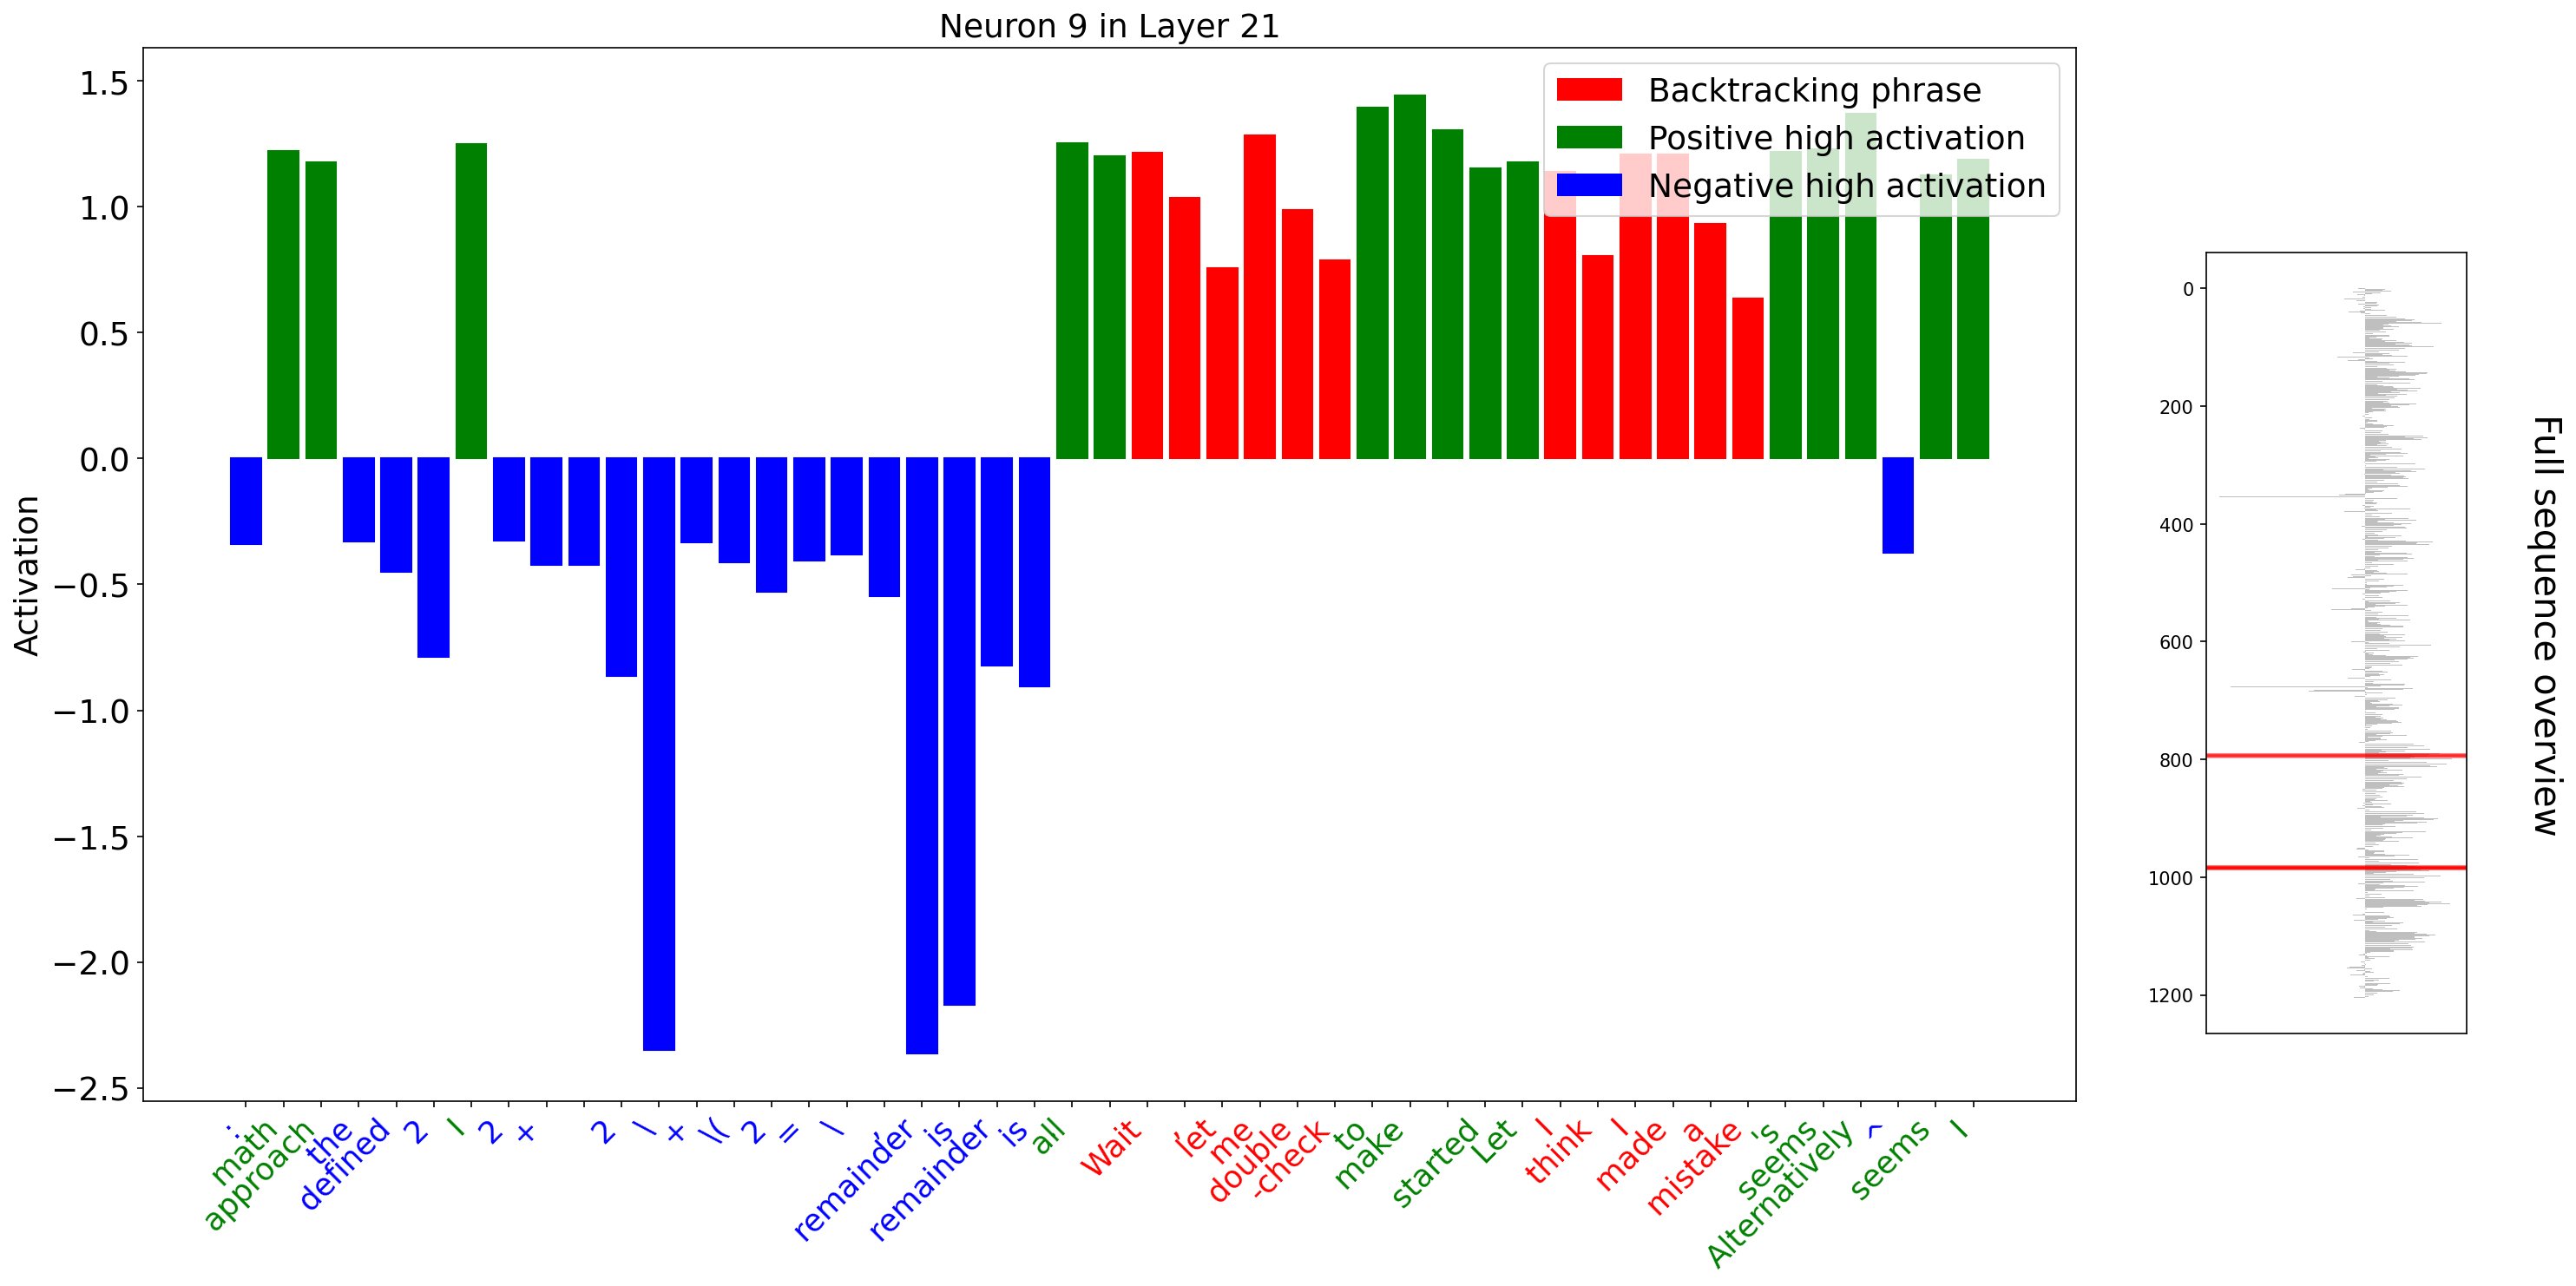

In [23]:
fig = visualize_neuron_activations(
    model=model, 
    neuron_info_list=[{'layer': 21, 'neuron': 9}], 
    examples=[example]
)

In [6]:
def visualize_attention(model, example_text, window_size=100, layer_id=None, head_id=None, avg_over_heads=False):
    """
    Visualize attention patterns using CircuitsVis.
    
    Args:
        model: The HookedTransformer model
        example_text: A single text example
        window_size: Number of tokens to include in the visualization window
        layer_id: The layer to visualize, if None, visualize all layers
        head_id: The head to visualize, if None, visualize all heads or average over heads
        avg_over_heads: If True, average attention over heads for each layer
        
    Returns:
        CircuitsVis visualization
    """    
    # Get tokens and run model with cache
    tokens = model.to_tokens(example_text)
    str_tokens = model.to_str_tokens(example_text)
    
    # Run with cache to get attention patterns
    _, cache = model.run_with_cache(tokens)
    
    # Find backtracking phrases in the example
    backtracking_positions = []
    for phrase in backtracking_phrases:
        phrase_tokens = model.to_str_tokens(phrase.lower())
        
        # Look for this phrase in the token sequence
        for i in range(len(str_tokens) - len(phrase_tokens) + 1):
            match = True
            for j in range(len(phrase_tokens)):
                if i+j >= len(str_tokens) or str_tokens[i+j].strip().lower() != phrase_tokens[j].strip().lower():
                    match = False
                    break
            
            if match:
                print(f"Backtracking phrase {phrase} found at position {i}")
                backtracking_positions.append(i)
    
    # Determine window for visualization centered around first backtracking phrase
    if backtracking_positions:
        center_pos = backtracking_positions[-1]
        half_window = window_size // 2
        start_pos = max(0, center_pos - half_window)
        end_pos = min(len(str_tokens), start_pos + window_size)
        
        # Adjust start_pos if end_pos hits the boundary
        if end_pos == len(str_tokens) and len(str_tokens) > window_size:
            start_pos = len(str_tokens) - window_size
    else:
        # Default to beginning if no backtracking found
        start_pos = 0
        end_pos = min(len(str_tokens), start_pos + window_size)
    
    # Get attention patterns for all layers
    attention_patterns = []
    for layer in range(model.cfg.n_layers):
        if layer_id is not None and layer != layer_id: continue
        if avg_over_heads:
            # Average over heads dimension
            avg_attn = cache["pattern", layer][0].mean(dim=0, keepdim=True)
            attention_patterns.append(avg_attn)
        elif head_id is not None:
            attention_patterns.append(cache["pattern", layer][0, head_id])
        else:
            attention_patterns.append(cache["pattern", layer][0])
    
    # Create CircuitsVis visualization
    window_tokens = str_tokens[start_pos:end_pos]
    window_attention = [attn[:, start_pos:end_pos, start_pos:end_pos] for attn in attention_patterns]
    
    # Create attention head names
    attention_head_names = []
    for layer in range(len(window_attention)):
        if avg_over_heads:
            attention_head_names.append(f"Layer {layer} (avg)")
        elif head_id is not None:
            attention_head_names.append(f"L{layer}H{head_id}")
        else:
            for head in range(window_attention[layer].shape[0]):
                attention_head_names.append(f"L{layer}H{head}")
    
    # Flatten attention for CircuitsVis
    flat_attention = torch.cat([attn for attn in window_attention], dim=0)
    
    # Create CircuitsVis visualization
    vis = cv.attention.attention_patterns(tokens=window_tokens, attention=flat_attention)
    
    if torch.cuda.is_available():
        del cache
        torch.cuda.empty_cache()
    
    return vis

In [ ]:
attention_vis = visualize_attention(model, example, window_size=250, layer_id=0, avg_over_heads=False)
display(attention_vis)

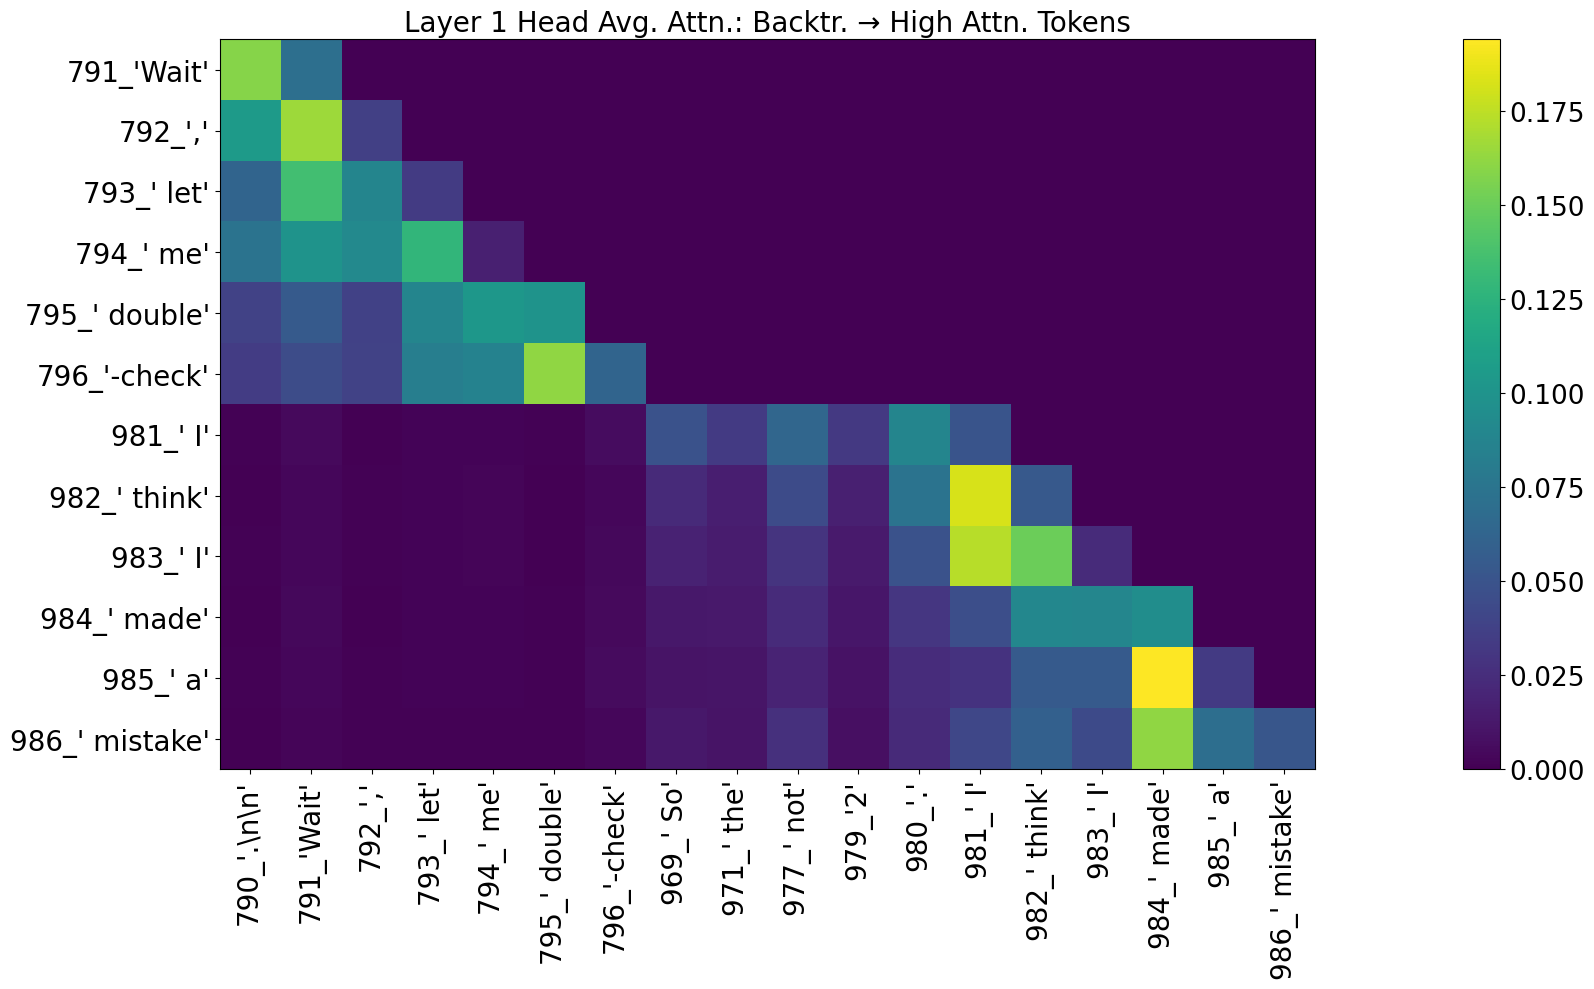

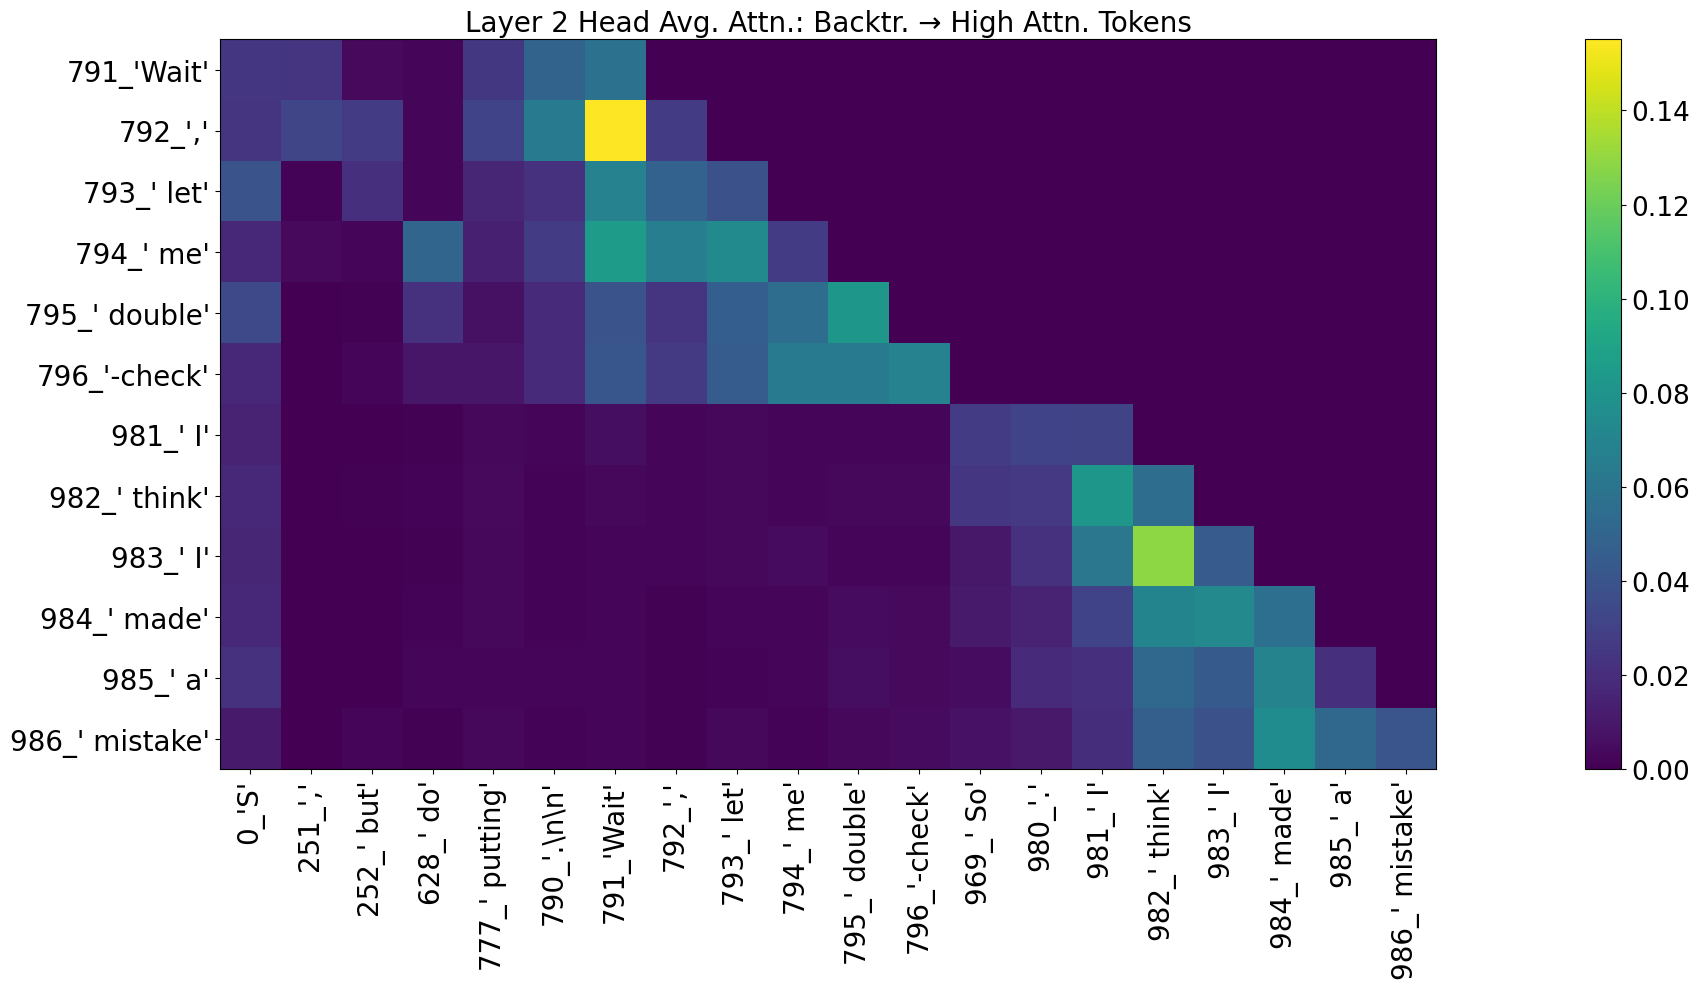

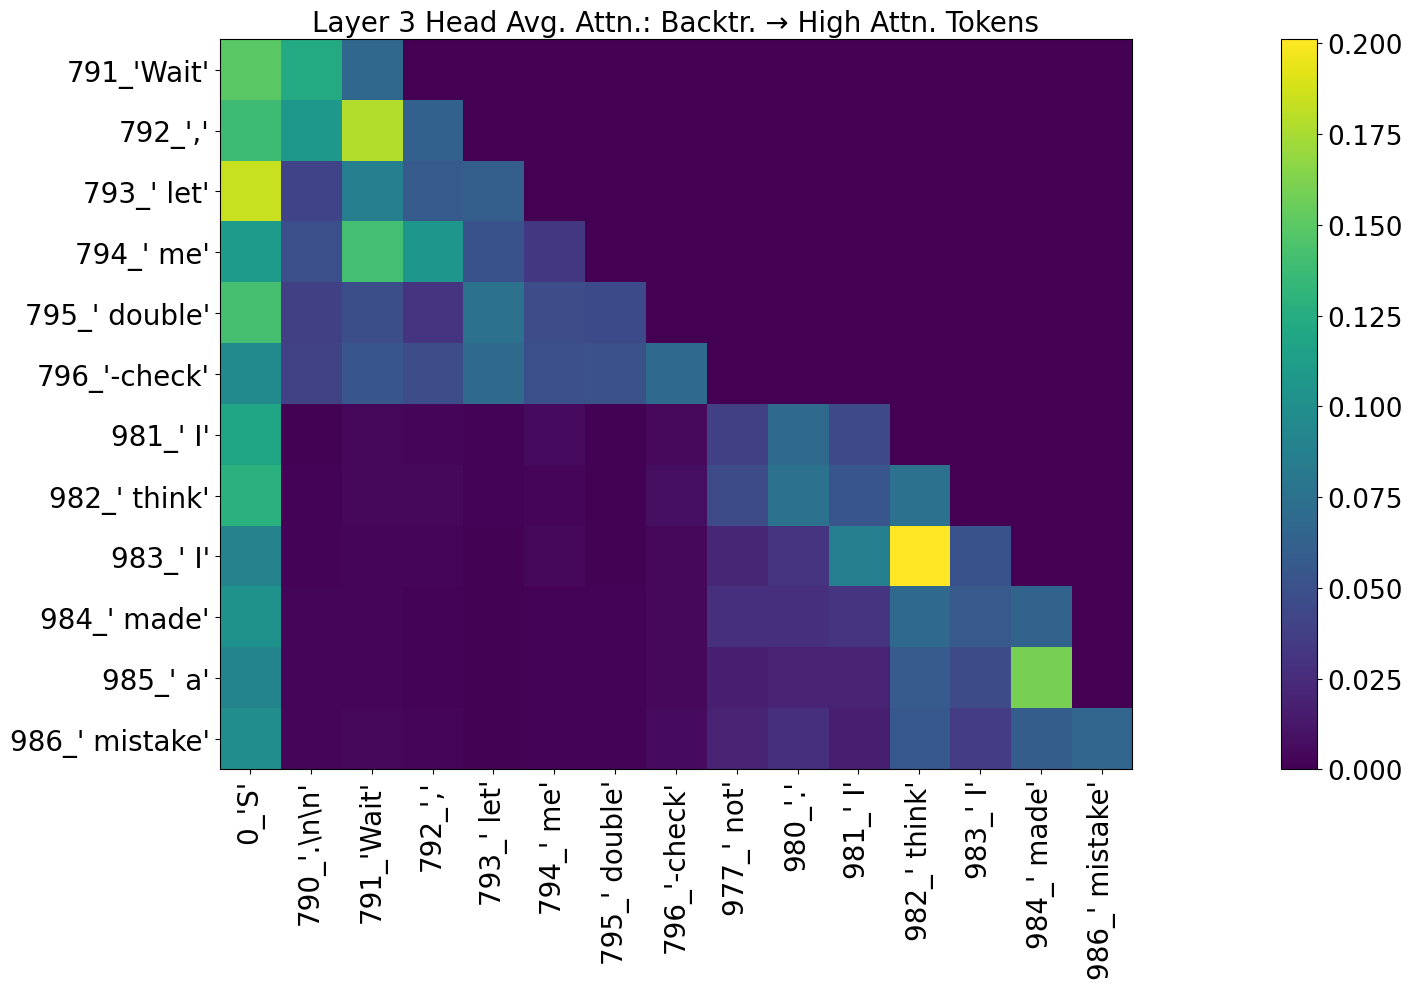

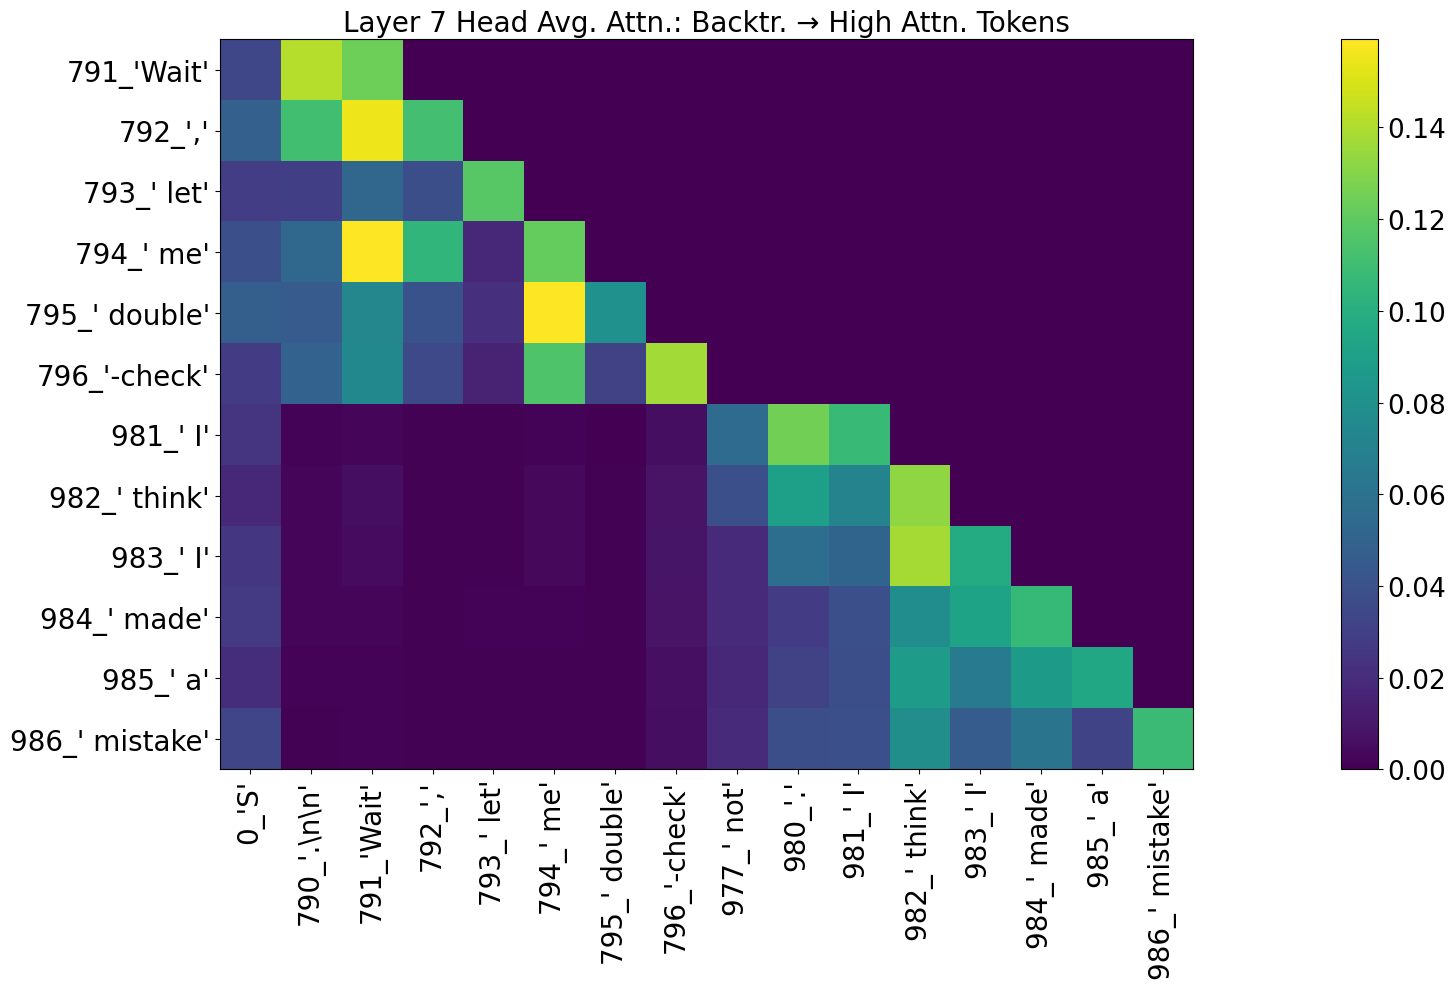

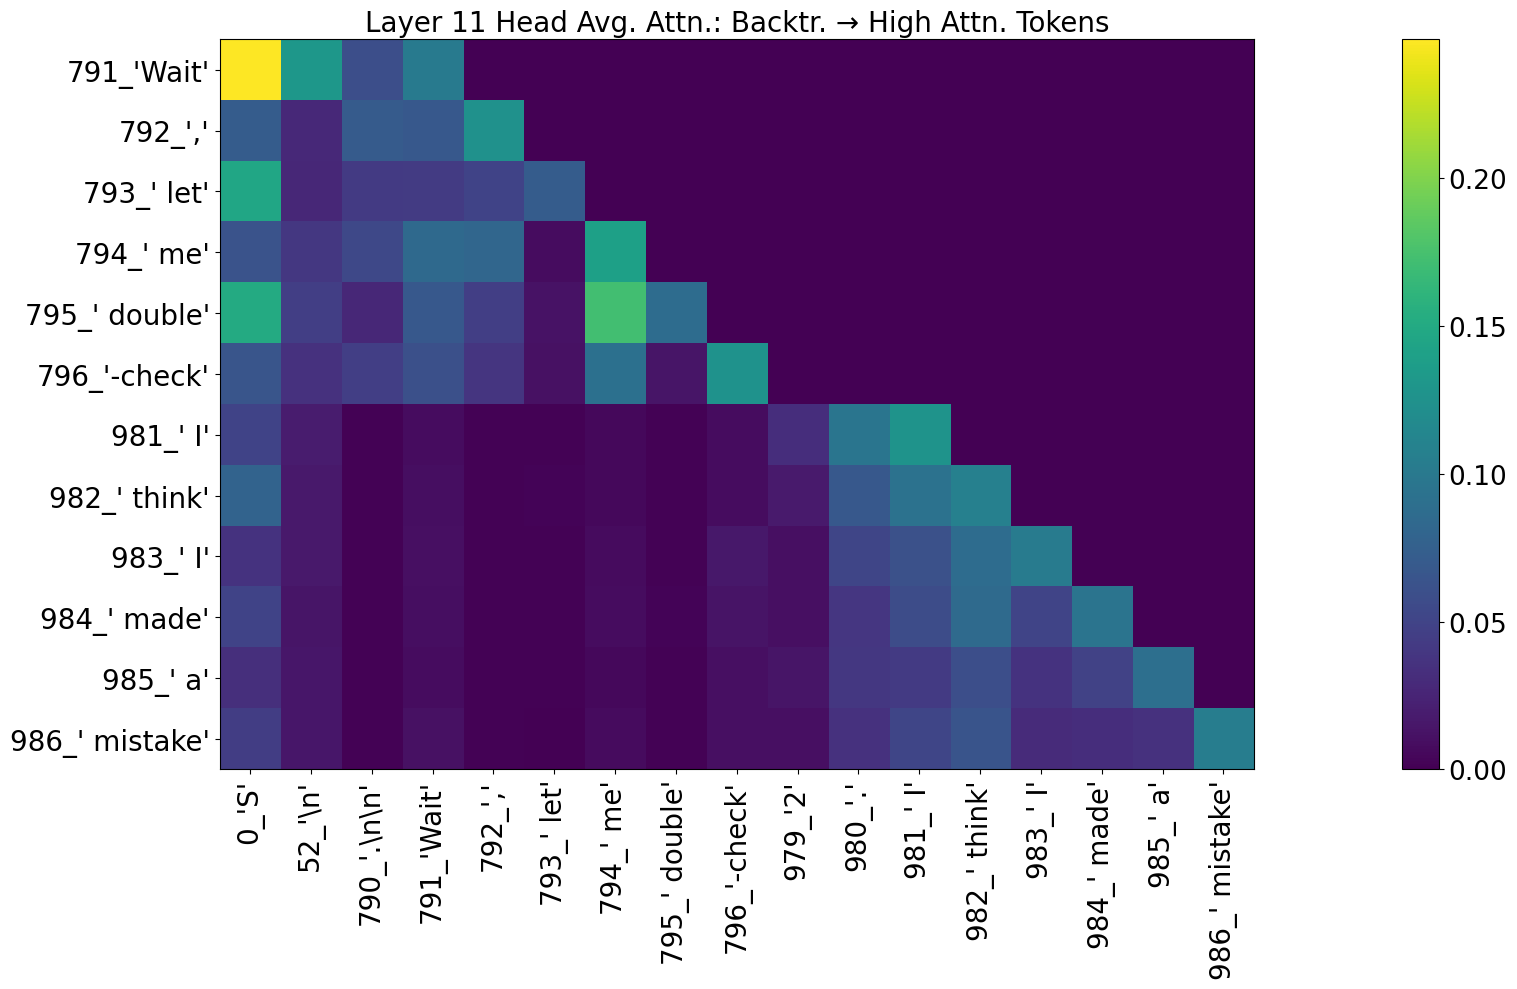

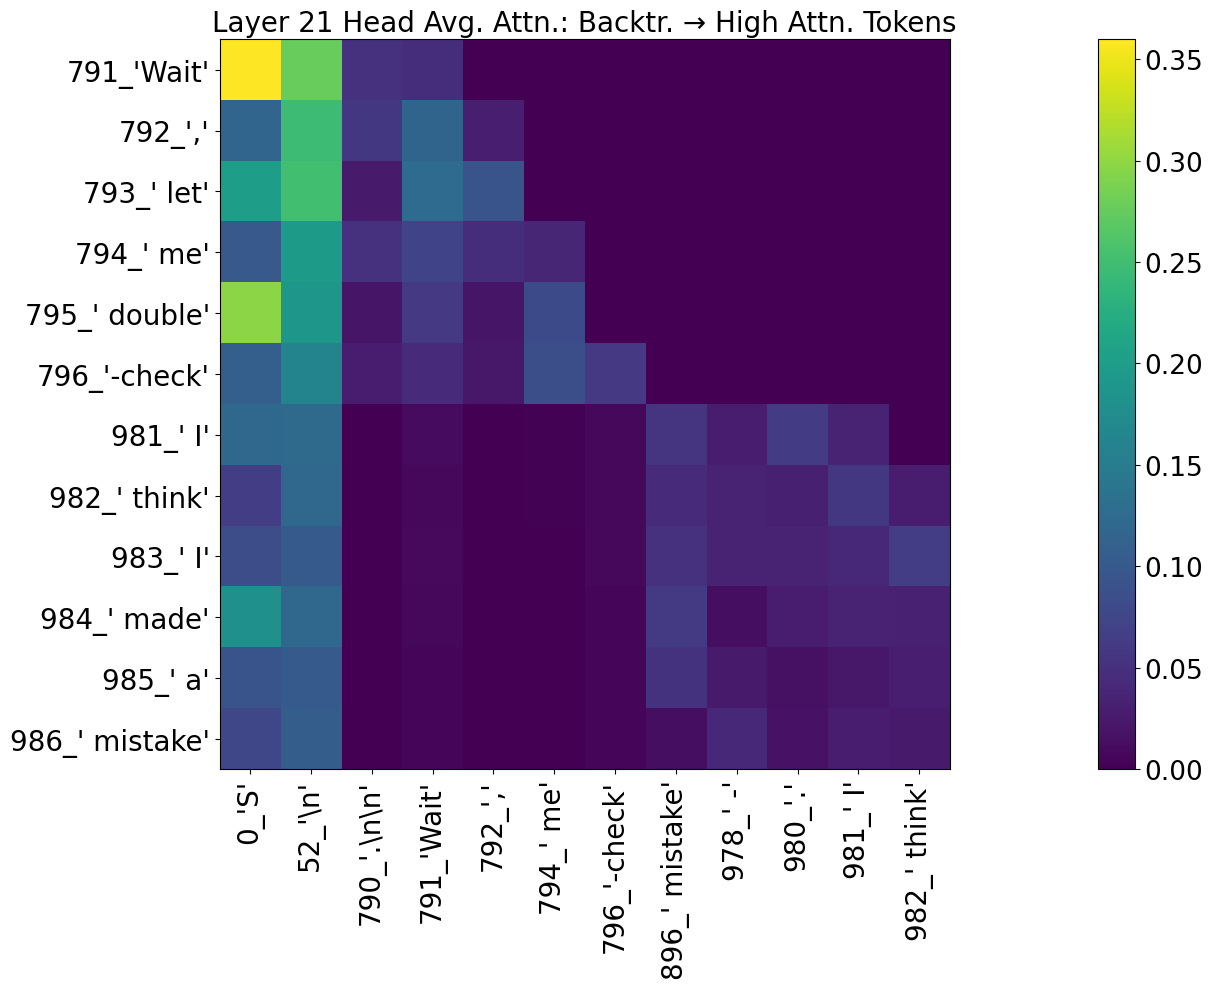

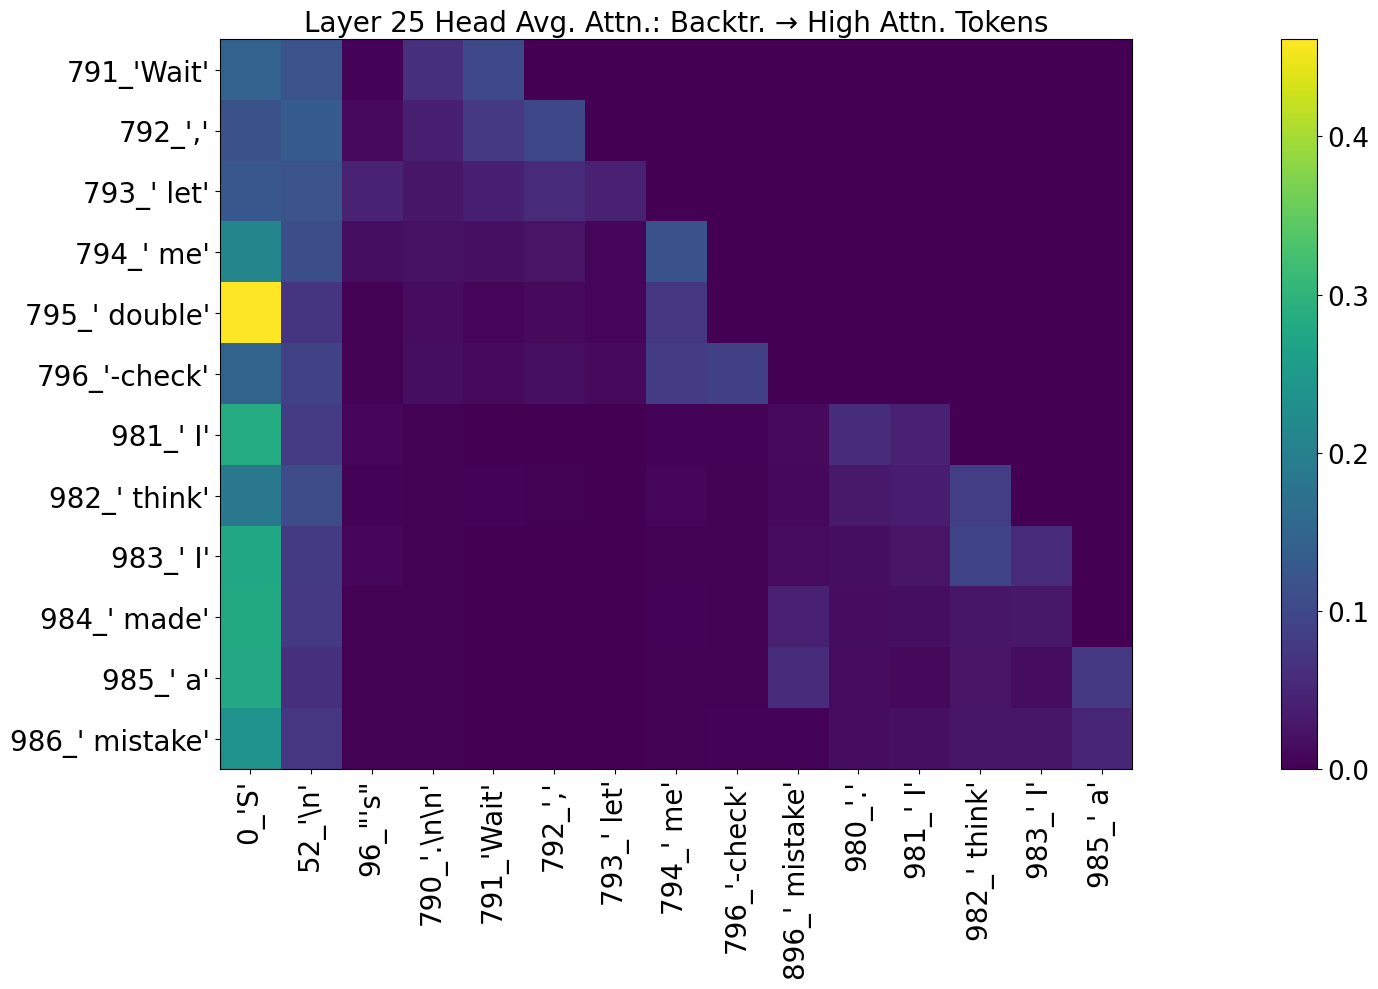

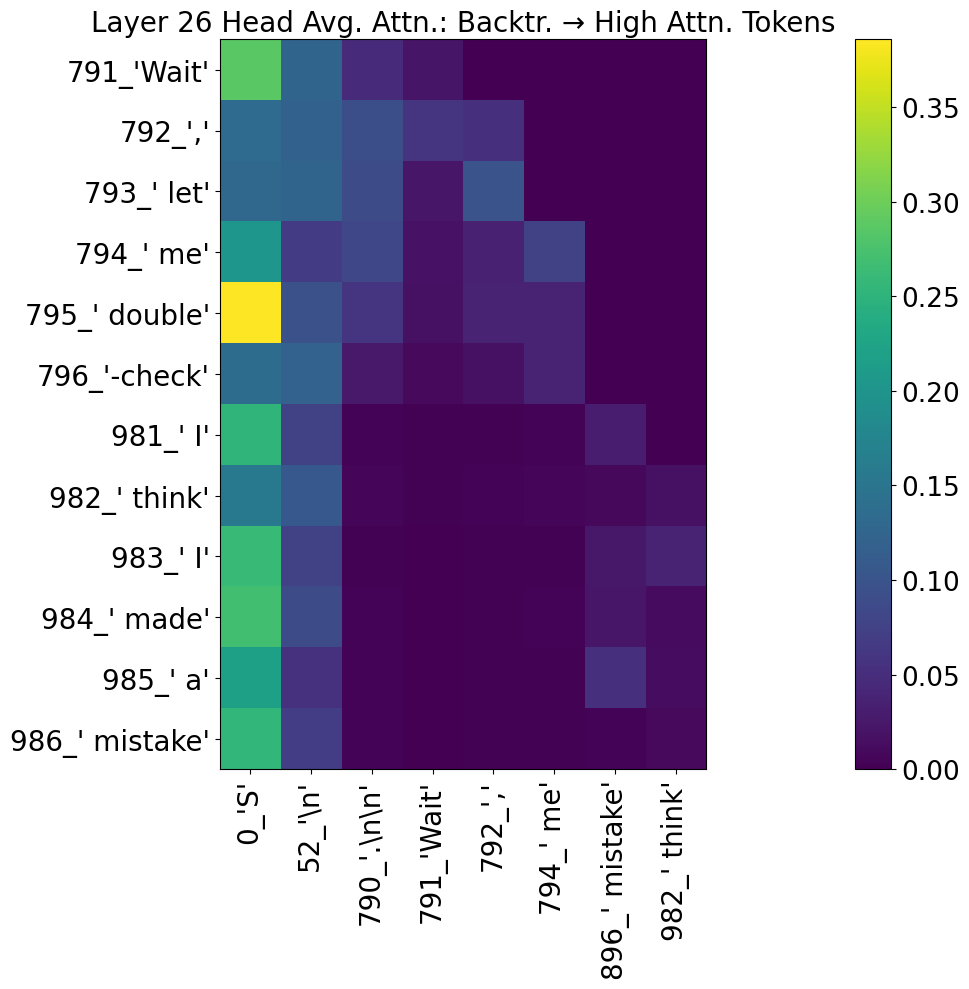

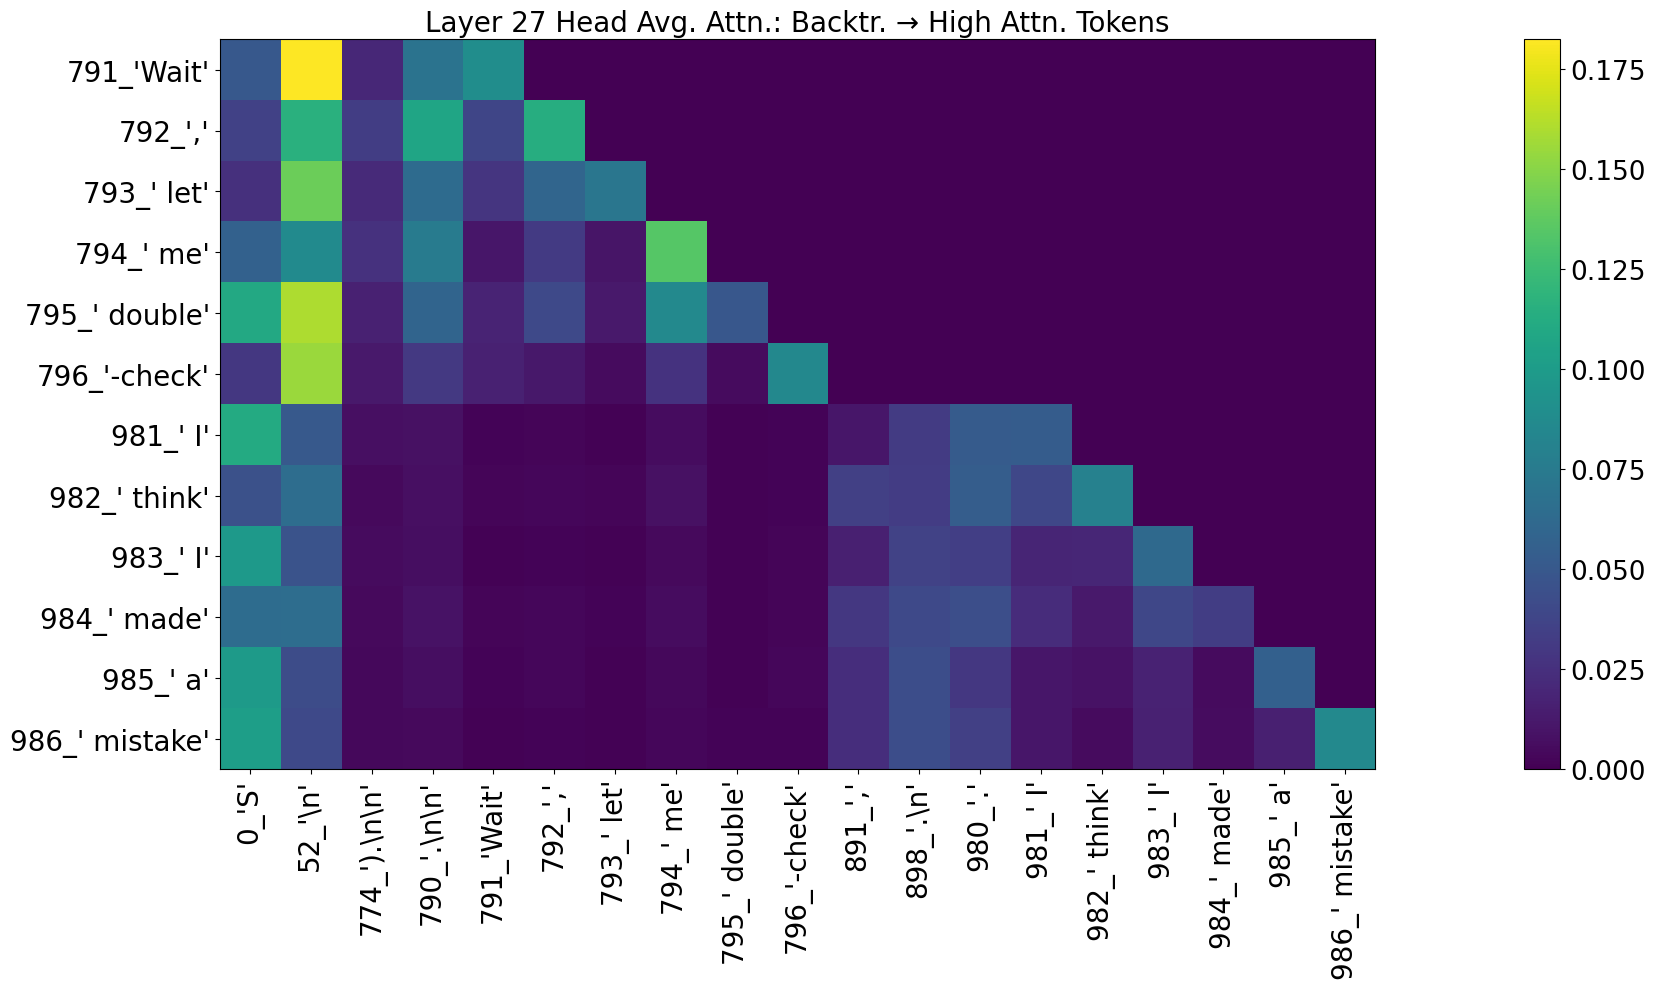

In [25]:
example = examples[0]["generated_cot"]
logits, cache = model.run_with_cache(example)
str_tokens = model.to_str_tokens(example)

layers = [1, 2, 3, 7, 11, 21, 25, 26, 27] # range(model.cfg.n_layers)
heads = range(model.cfg.n_heads)
avg_over_heads = True
focus = True

# Find backtracking phrases
backtracking_positions = identify_backtracking_positions(model, str_tokens)
            
# Filter to only include backtracking positions
if not backtracking_positions:
    print("No backtracking phrases found!")
    backtracking_indices = list(range(min(100, len(str_tokens))))
else:
    backtracking_indices = sorted(list(set(backtracking_positions)))

for layer in layers:
    for head in heads:      
        if avg_over_heads:
            attn_matrix = cache["attn", layer][0].mean(dim=0).detach().cpu().numpy()
        else:
            attn_matrix = cache["attn", layer][0, head].detach().cpu().numpy()

        # Calculate attention threshold (mean + 1 std)
        attention_threshold = np.mean(attn_matrix) + 5 * np.std(attn_matrix)

        # For each backtracking token, find tokens it attends to with high attention
        high_attention_indices = []
        for idx in backtracking_indices:
            # Find indices where attention is above threshold
            high_attn_to = np.where(attn_matrix[idx, :] > attention_threshold)[0]
            high_attention_indices.extend(high_attn_to)

        # Remove duplicates and sort
        high_attention_indices = sorted(list(set(high_attention_indices)))

        # Create filtered attention matrix
        if focus:
            filtered_attn = attn_matrix[backtracking_indices, :][:, high_attention_indices]
        else:
            filtered_attn = attn_matrix

        # Create token labels with indices
        if focus:
            x_token_labels = [f"{i}_{repr(str_tokens[i])}" for i in backtracking_indices]
            y_token_labels = [f"{i}_{repr(str_tokens[i])}" for i in high_attention_indices]
        else:
            x_token_labels = [f"{i}_{repr(str_tokens[i])}" for i in range(len(str_tokens))]
            y_token_labels = [f"{i}_{repr(str_tokens[i])}" for i in range(len(str_tokens))]

        # Create visualization
        fig, ax = plt.subplots(figsize=(30, 10))
        im = ax.imshow(filtered_attn)

        # Set the ticks and labels with larger font sizes
        ax.set_xticks(range(len(y_token_labels)))
        ax.set_yticks(range(len(x_token_labels)))
        ax.set_xticklabels(y_token_labels, rotation=90, fontsize=20)
        ax.set_yticklabels(x_token_labels, fontsize=20)

        # Add a title with larger font size
        ax.set_title(f"Layer {layer} Head {head if not avg_over_heads else 'Avg.'} Attn.: Backtr. → High Attn. Tokens", fontsize=20)

        # Add a colorbar with larger font size
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize=19)

        # Adjust layout to make room for the labels
        plt.tight_layout()

        # Show the plot
        plt.show()
        
        if avg_over_heads:
            break

if torch.cuda.is_available():
    del cache
    torch.cuda.empty_cache()

In [6]:
def get_log_probs(logits: torch.Tensor, tokens: torch.Tensor) -> torch.Tensor:
    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = (
        log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    )

    return log_probs_for_tokens

def analyze_backtracking_loss(model, example):
    """
    Analyze token-by-token loss before, during, and after backtracking events.
    """
    tokens = model.to_tokens(example)
    logits, cache = model.run_with_cache(tokens)
    str_tokens = model.to_str_tokens(example)
    
    # Find backtracking phrases
    backtracking_positions = []
    for phrase in backtracking_phrases:
        phrase_tokens = model.to_str_tokens(phrase.lower())
        
        # Look for this phrase in the token sequence
        for i in range(len(str_tokens) - len(phrase_tokens) + 1):
            match = True
            for j in range(len(phrase_tokens)):
                if str_tokens[i+j].strip().lower() != phrase_tokens[j].strip().lower():
                    match = False
                    break
            
            if match:
                backtracking_positions.extend(range(i, i + len(phrase_tokens)))
    
    # Calculate loss for each token
    log_probs = get_log_probs(logits, tokens).squeeze()
    
    # Define regions
    pre_backtracking = []
    during_backtracking = []
    post_backtracking = []
    
    if backtracking_positions:
        bt_start = min(backtracking_positions)
        bt_end = max(backtracking_positions)
        
        pre_backtracking = log_probs[max(0, bt_start-20):bt_start]
        during_backtracking = log_probs[bt_start:bt_end+1]
        post_backtracking = log_probs[bt_end+1:min(len(log_probs), bt_end+21)]
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(log_probs)), log_probs.detach().cpu().numpy(), alpha=0.3, color='gray')
    
    if backtracking_positions:
        plt.axvspan(bt_start, bt_end, color='red', alpha=0.2, label='Backtracking')
        plt.axvspan(max(0, bt_start-20), bt_start, color='blue', alpha=0.2, label='Pre-backtracking')
        plt.axvspan(bt_end+1, min(len(log_probs), bt_end+21), color='green', alpha=0.2, label='Post-backtracking')
        
        print(f"Average loss - Pre-backtracking: {pre_backtracking.mean():.4f}")
        print(f"Average loss - During backtracking: {during_backtracking.mean():.4f}")
        print(f"Average loss - Post-backtracking: {post_backtracking.mean():.4f}")
    
    plt.title("Token-by-token loss with backtracking highlighted")
    plt.xlabel("Token position")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    if torch.cuda.is_available():
        del cache
        torch.cuda.empty_cache()

Average loss - Pre-backtracking: -0.1390
Average loss - During backtracking: -0.2312
Average loss - Post-backtracking: -0.5881


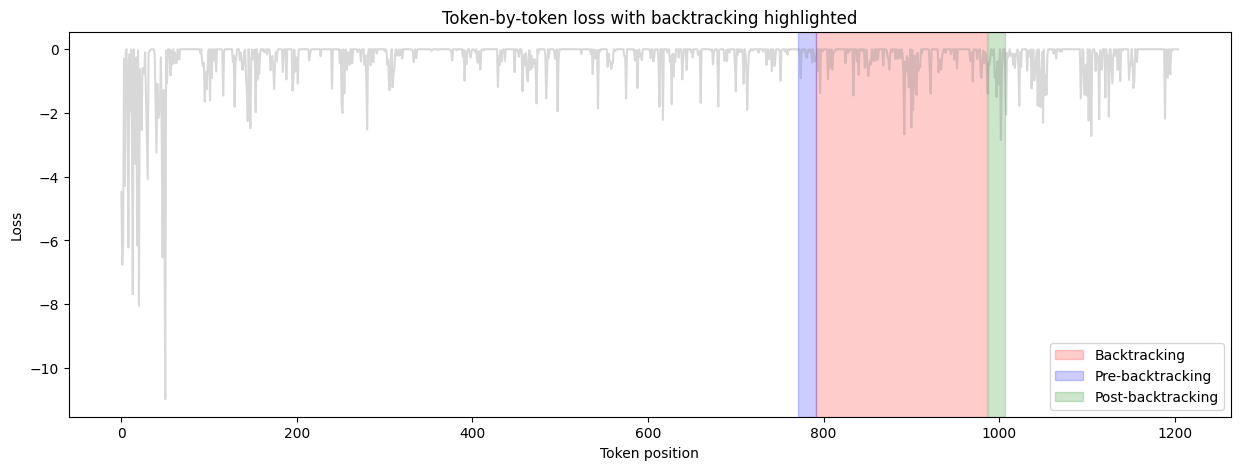

In [7]:
logits, cache = model.run_with_cache(example)
analyze_backtracking_loss(model, example)
del cache
torch.cuda.empty_cache()

Average loss - Pre-backtracking: -0.2570
Average loss - During backtracking: -0.5039
Average loss - Post-backtracking: -0.3860


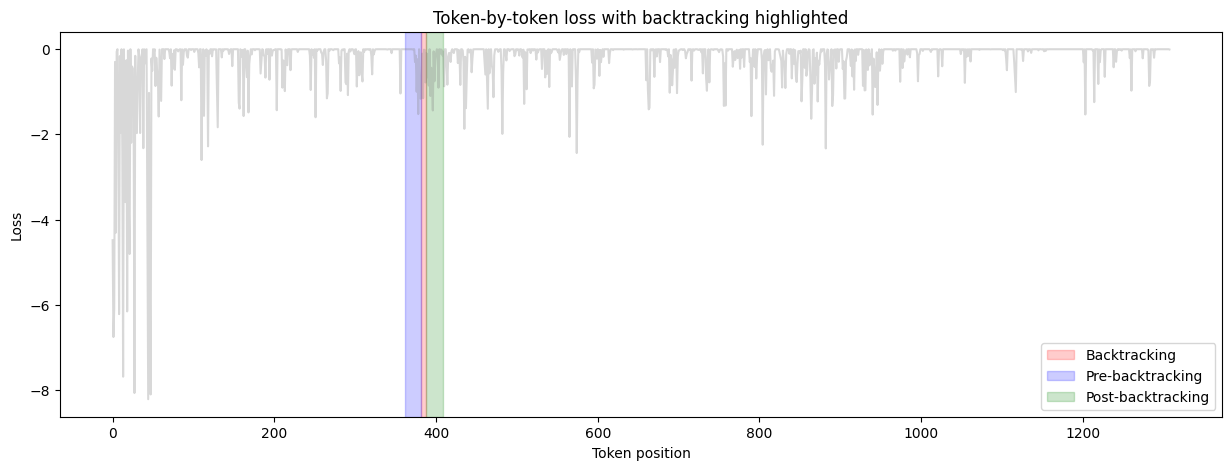

In [8]:
logits, cache = model.run_with_cache(examples[1]["generated_cot"])
analyze_backtracking_loss(model, examples[1]["generated_cot"])
del cache
torch.cuda.empty_cache()

In [44]:
def cluster_backtracking_neurons(model, json_file_path, n_clusters=5):
    """
    Cluster neurons based on their activation patterns during backtracking.
    """
    # Collect activations during backtracking
    backtracking_activations = []
    neuron_indices = []  # Store layer and neuron indices
    
    with open(json_file_path, "r") as f:
        dataset = json.load(f)
    
    for data in tqdm(dataset, desc="Processing examples"):
        generated_cot = data["generated_cot"]
        tokens = model.to_tokens(generated_cot)
        _, cache = model.run_with_cache(tokens)
        str_tokens = model.to_str_tokens(generated_cot)
        
        # Find backtracking positions
        backtracking_positions = identify_backtracking_positions(model, str_tokens)
        
        if not backtracking_positions: continue
        
        # Get non-backtracking positions for comparison
        all_positions = set(range(len(str_tokens)))
        non_backtracking_positions = list(all_positions - set(backtracking_positions))
        
        # Extract activations for all neurons
        for layer in range(model.cfg.n_layers):
            # Get activations for all neurons in this layer
            layer_activations = cache["post", layer][0]
            
            # For each neuron in the layer
            for neuron_idx in range(layer_activations.shape[-1]):
                # Get activations during backtracking and non-backtracking
                bt_activations = layer_activations[backtracking_positions, neuron_idx]
                non_bt_activations = layer_activations[non_backtracking_positions, neuron_idx]
                
                # Calculate Cohen's d effect size
                bt_mean = bt_activations.mean().item()
                non_bt_mean = non_bt_activations.mean().item()
                # Pooled standard deviation
                pooled_std = torch.sqrt((bt_activations.var() + non_bt_activations.var()) / 2).item()
                # Avoid division by zero
                eps = 1e-6
                effect_size = (bt_mean - non_bt_mean) / (pooled_std + eps)
                
                backtracking_activations.append([effect_size])
                neuron_indices.append((layer, neuron_idx))
            
        del cache
        torch.cuda.empty_cache()
    
    # Stack all examples
    if not backtracking_activations:
        return None
        
    print(f"Total neurons collected: {len(backtracking_activations)}")
    activations_matrix = np.array(backtracking_activations)
    print(f"Activation matrix shape: {activations_matrix.shape}")
    
    # No need to normalize since we're already using effect sizes
    
    # Cluster the neurons
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(activations_matrix)
    
    neuron_info_list = []
    
    # Analyze clusters
    for cluster_id in range(n_clusters):
        cluster_neurons = np.where(clusters == cluster_id)[0]
        print(f"Cluster {cluster_id}: {len(cluster_neurons)} neurons")
        
        # Get top neurons in this cluster (closest to centroid)
        centroid = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(activations_matrix[cluster_neurons] - centroid, axis=1)
        top_indices = np.argsort(distances)[:5]
        top_examples = [cluster_neurons[i] for i in top_indices]
        
        print("Top examples in this cluster:")
        for ex_idx in top_examples:
            neuron_layer, neuron_idx = neuron_indices[ex_idx]
            print(f"Example {ex_idx} - Layer: {neuron_layer}, Neuron: {neuron_idx}")
            neuron_info_list.append({"layer": neuron_layer, "neuron": neuron_idx})
    
    return clusters, kmeans, neuron_info_list

In [45]:
clusters, kmeans, neuron_info_list = cluster_backtracking_neurons(model, "backtracking_dataset_n=10.json", n_clusters=8)

Processing examples:  10%|█         | 1/10 [00:00<00:01,  4.91it/s]

Backtracking phrase 'i made a mistake' found at positions 801-804
Backtracking phrase 'that's not right' found at positions 787-790
Backtracking phrase 'wait, that's not' found at positions 722-726
Backtracking phrase 'wait, let me double-check' found at positions 748-753


Processing examples:  20%|██        | 2/10 [02:18<10:49, 81.19s/it]

Backtracking phrase 'i made a mistake' found at positions 719-722


Processing examples:  50%|█████     | 5/10 [04:29<03:21, 40.40s/it] 

Backtracking phrase 'wait, let me double-check' found at positions 464-469


Processing examples:  70%|███████   | 7/10 [06:08<02:01, 40.61s/it]

Backtracking phrase 'that's not right' found at positions 723-726


Processing examples:  80%|████████  | 8/10 [07:54<02:03, 61.60s/it]

Backtracking phrase 'i made a mistake' found at positions 1948-1951
Backtracking phrase 'let me think again' found at positions 1942-1945


Processing examples:  90%|█████████ | 9/10 [10:13<01:25, 85.61s/it]

Backtracking phrase 'i made a mistake' found at positions 1455-1458
Backtracking phrase 'wait, let me double-check' found at positions 1054-1059


Processing examples: 100%|██████████| 10/10 [12:31<00:00, 75.12s/it] 


Total neurons collected: 1505280
Activation matrix shape: (1505280, 1)
Cluster 0: 347324 neurons
Top examples in this cluster:
Example 239988 - Layer: 26, Neuron: 7028
Example 529498 - Layer: 3, Neuron: 858
Example 1459696 - Layer: 22, Neuron: 8176
Example 1264212 - Layer: 1, Neuron: 852
Example 1368423 - Layer: 12, Neuron: 6503
Cluster 1: 128251 neurons
Top examples in this cluster:
Example 851514 - Layer: 11, Neuron: 314
Example 436468 - Layer: 20, Neuron: 6388
Example 572939 - Layer: 7, Neuron: 8459
Example 938121 - Layer: 20, Neuron: 6281
Example 387823 - Layer: 15, Neuron: 2543
Cluster 2: 106514 neurons
Top examples in this cluster:
Example 869351 - Layer: 13, Neuron: 231
Example 1426746 - Layer: 19, Neuron: 2106
Example 1232418 - Layer: 25, Neuron: 4898
Example 877698 - Layer: 13, Neuron: 8578
Example 479153 - Layer: 25, Neuron: 4273
Cluster 3: 270390 neurons
Top examples in this cluster:
Example 956814 - Layer: 22, Neuron: 7054
Example 507240 - Layer: 0, Neuron: 5480
Example 526

Processing neurons:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_82989/249353541.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing neurons: 100%|██████████| 40/40 [01:55<00:00,  2.89s/it]

Sample visualization:


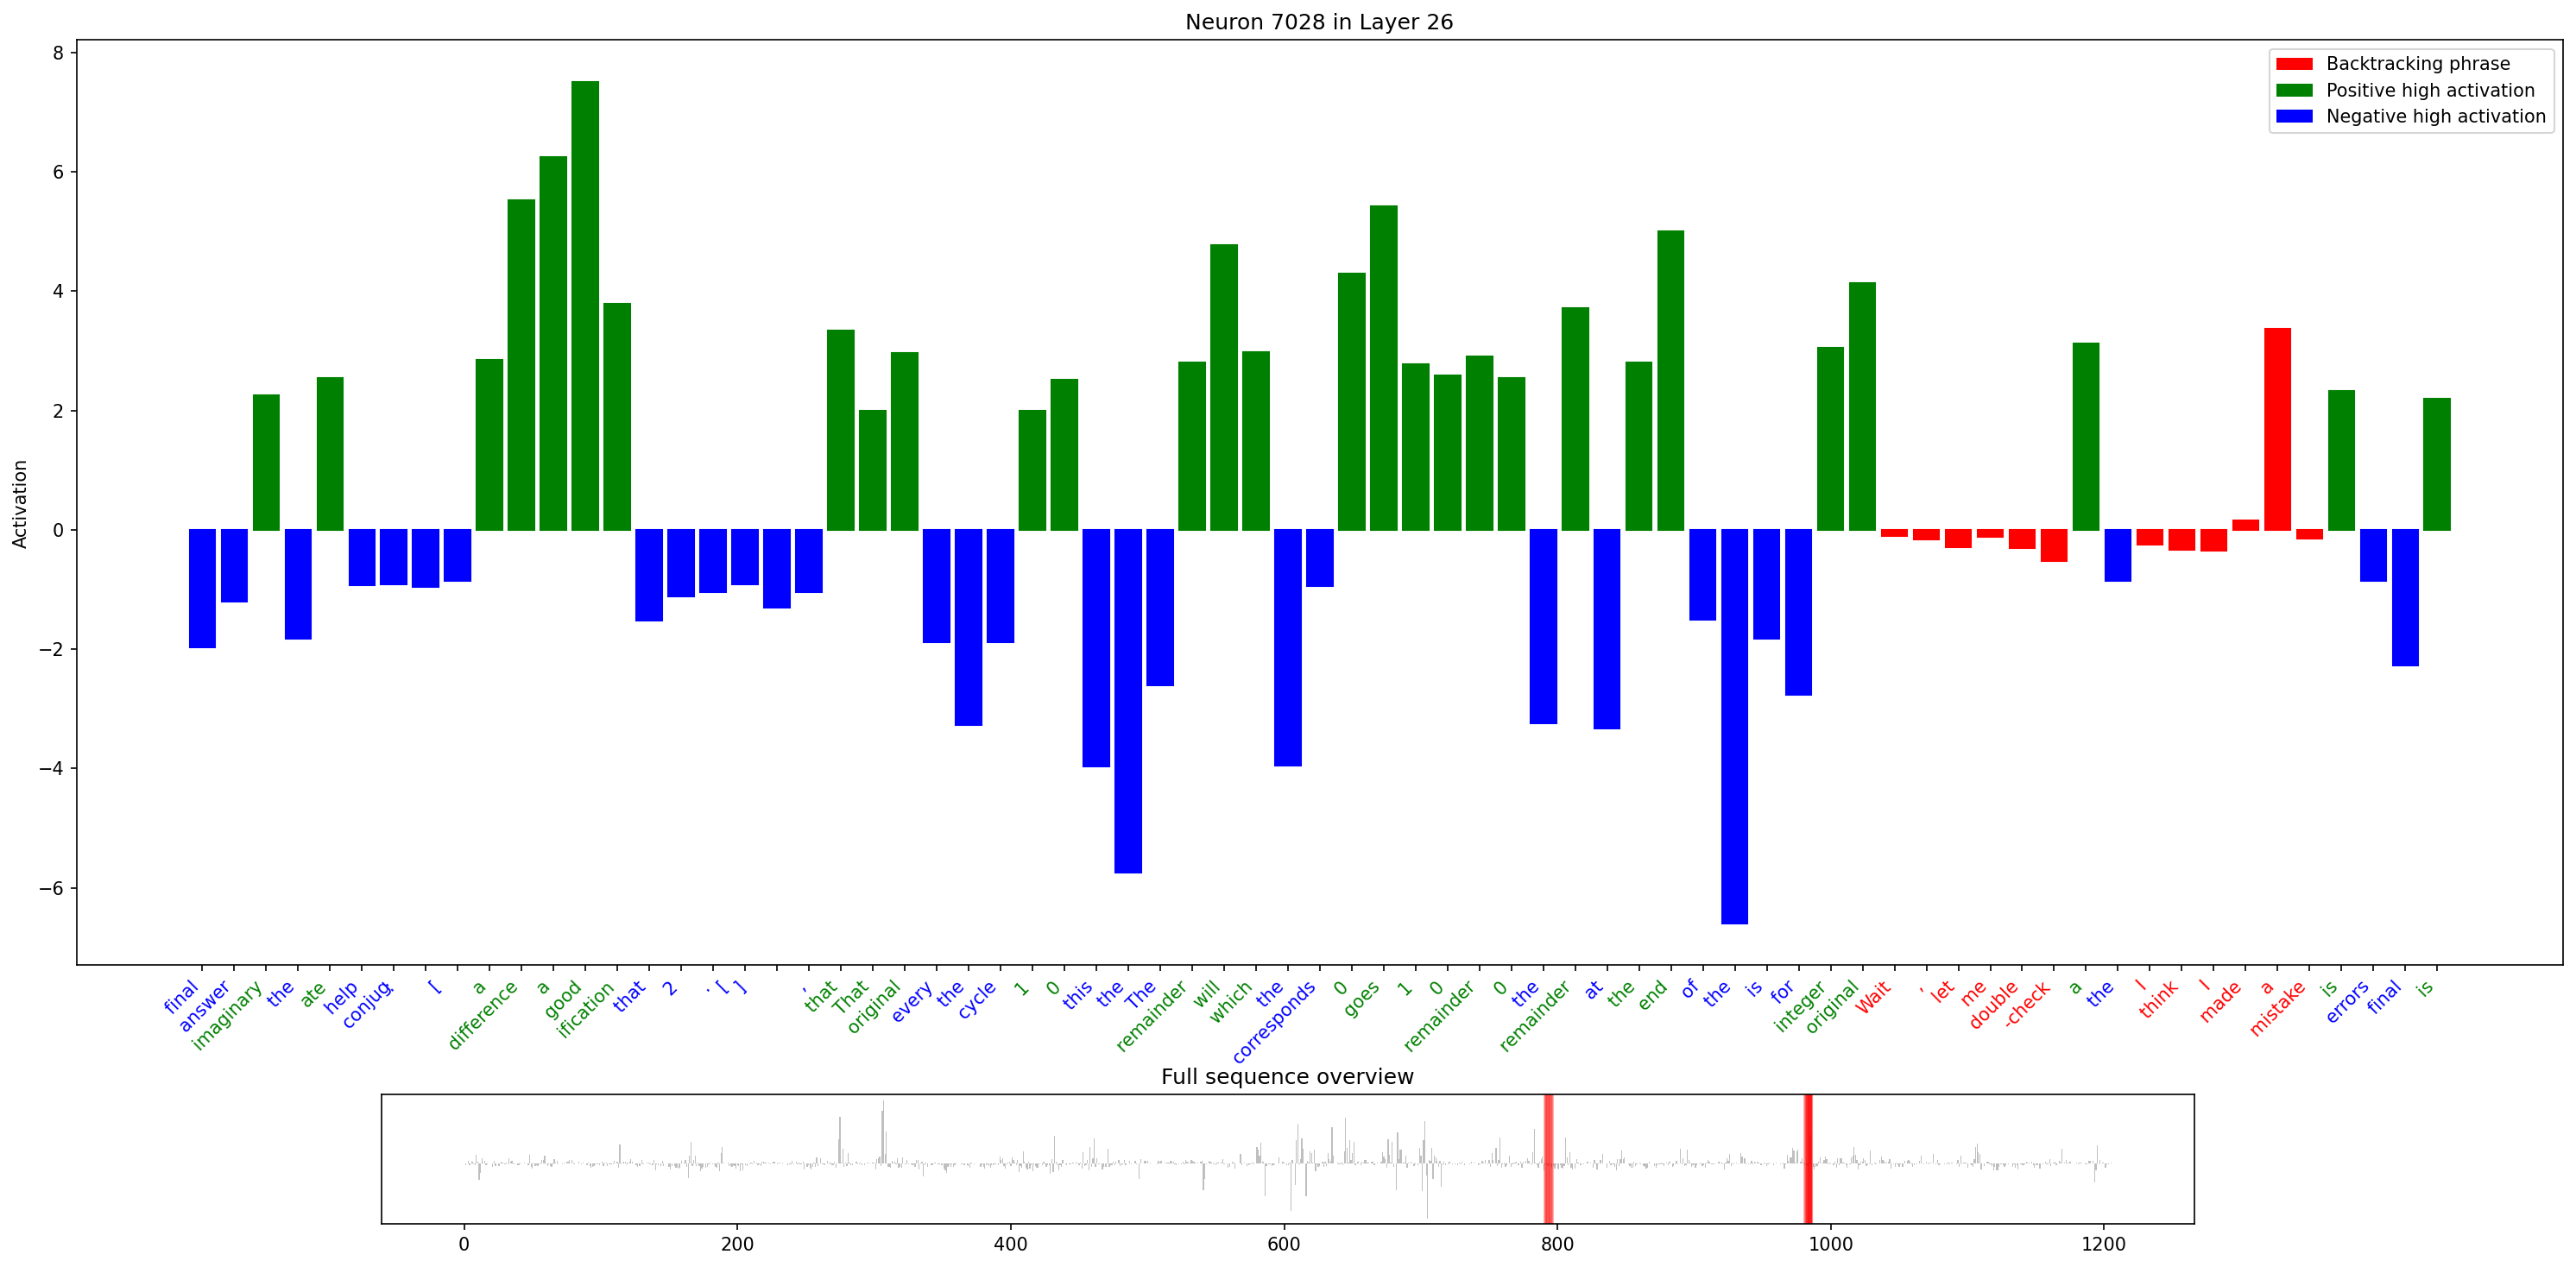

In [46]:
fig = visualize_neuron_activations(model=model, neuron_info_list=neuron_info_list, examples=[example])

In [10]:
def backtracking_attention_detector(cache, backtracking_positions, threshold=0.01):
    """
    Identify heads that show distinctive attention patterns during backtracking.
    Similar to induction head detection, but focused on backtracking phrases.
    """
    backtracking_heads = []
    
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["attn", layer][0, head].detach().cpu().numpy()
            
            # Calculate attention from backtracking tokens to previous calculation tokens
            backtracking_scores = []
            for bt_pos in backtracking_positions:
                # Look at where backtracking tokens are attending - particularly interested in attention to earlier calculation steps
                calculation_region = range(max(0, bt_pos - 50), bt_pos)
                if calculation_region:
                    score = attention_pattern[bt_pos, calculation_region].mean()
                    backtracking_scores.append(score)
            
            if backtracking_scores and np.mean(backtracking_scores) > threshold:
                backtracking_heads.append(f"{layer}.{head}")
    
    return backtracking_heads

In [13]:
logits, cache = model.run_with_cache(example)
str_tokens = model.to_str_tokens(example)
backtracking_positions = identify_backtracking_positions(model, str_tokens)
backtracking_heads = backtracking_attention_detector(cache, backtracking_positions, threshold=0.015)
print("Backtracking heads:", backtracking_heads)

del cache
torch.cuda.empty_cache()

Backtracking phrase 'i made a mistake' found at positions 983-986
Backtracking phrase 'i think i made a mistake' found at positions 981-986
Backtracking phrase 'wait, let me double-check' found at positions 791-796
Backtracking heads: ['0.2', '0.8', '0.11', '1.0', '1.1', '1.3', '1.4', '1.9', '5.8', '7.7', '7.8', '7.9', '8.0', '9.4', '13.4', '18.8', '18.11', '21.3', '22.2']


Loading dataset from backtracking_dataset_n=1000.json...
Total examples: 1000
Examples with backtracking: 500 (50.0%)
Correct examples: 853 (85.3%)
Examples with <think> tokens: 997 (99.7%)

P(correct | backtracking): 100.0%
P(correct | no backtracking): 70.6%

Chi-square test (backtracking vs correctness):
Chi2 value: 170.00, p-value: 0.0000
Statistically significant relationship: Yes

Phi coefficient (correlation):
Backtracking vs Correctness: 0.415
Backtracking vs Think tokens: -0.055
Correctness vs Think tokens: -0.023


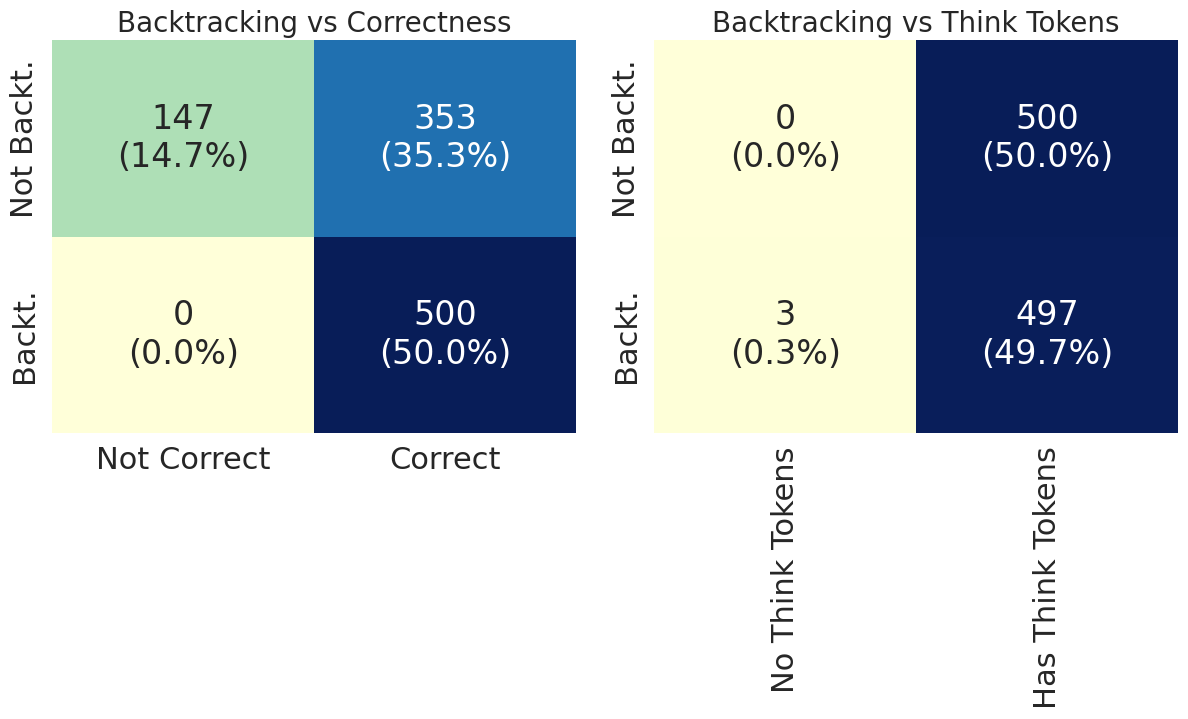


Analysis by Problem Type:
                        count  correctness_rate  think_tokens_rate
problem_type                                                      
Algebra                   307          0.869707           1.000000
Prealgebra                232          0.836207           1.000000
Number Theory             116          0.931034           1.000000
Counting & Probability    108          0.833333           1.000000
Intermediate Algebra       91          0.824176           1.000000
Precalculus                78          0.833333           0.961538
Geometry                   68          0.794118           1.000000


In [26]:
def analyze_backtracking_dataset(dataset_path):
    """
    Analyze the backtracking dataset to understand relationships between
    backtracking, correctness, and thinking tokens.
    
    Args:
        dataset_path: Path to the backtracking dataset JSON file
    """
    # Load the dataset
    print(f"Loading dataset from {dataset_path}...")
    with open(dataset_path, "r") as f:
        data = json.load(f)
    
    # Extract key features for each example
    features = []
    for item in data:
        has_backtracking = item.get("has_backtracking", False)
        is_correct = item.get("is_correct", False)
        has_think_tokens = "</think>" in item.get("generated_cot", "")
        
        features.append({
            "has_backtracking": has_backtracking,
            "is_correct": is_correct,
            "has_think_tokens": has_think_tokens,
            "problem_type": item.get("problem_type", "Unknown"),
            "problem_level": item.get("problem_level", "Unknown")
        })
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(features)
    
    # 1. Basic counts and percentages
    total_examples = len(df)
    backtracking_count = df["has_backtracking"].sum()
    correct_count = df["is_correct"].sum()
    think_tokens_count = df["has_think_tokens"].sum()
    
    print(f"Total examples: {total_examples}")
    print(f"Examples with backtracking: {backtracking_count} ({backtracking_count/total_examples:.1%})")
    print(f"Correct examples: {correct_count} ({correct_count/total_examples:.1%})")
    print(f"Examples with <think> tokens: {think_tokens_count} ({think_tokens_count/total_examples:.1%})")
    
    # 2. Create a contingency table (matrix)
    # For backtracking vs correctness
    backtracking_correct_matrix = pd.crosstab(
        df["has_backtracking"], 
        df["is_correct"], 
        margins=True, 
        margins_name="Total"
    )
    
    # Rename the index and columns for better visualization
    backtracking_correct_matrix.index = ["Not Backt.", "Backt.", "Total"] if False in backtracking_correct_matrix.index else ["Backt.", "Total"]
    backtracking_correct_matrix.columns = ["Not Correct", "Correct", "Total"] if False in backtracking_correct_matrix.columns else ["Correct", "Total"]
    
    # For backtracking vs think tokens
    backtracking_think_matrix = pd.crosstab(
        df["has_backtracking"], 
        df["has_think_tokens"], 
        margins=True, 
        margins_name="Total"
    )
    
    # Rename the index and columns for better visualization
    backtracking_think_matrix.index = ["Not Backt.", "Backt.", "Total"] if False in backtracking_think_matrix.index else ["Backt.", "Total"]
    backtracking_think_matrix.columns = ["No Think Tokens", "Has Think Tokens", "Total"] if False in backtracking_think_matrix.columns else ["Has Think Tokens", "Total"]
    
    # For correctness vs think tokens
    correct_think_matrix = pd.crosstab(
        df["is_correct"], 
        df["has_think_tokens"], 
        margins=True, 
        margins_name="Total"
    )
    
    # Rename the index and columns for better visualization
    correct_think_matrix.index = ["Not Correct", "Correct", "Total"] if False in correct_think_matrix.index else ["Correct", "Total"]
    correct_think_matrix.columns = ["No Think Tokens", "Has Think Tokens", "Total"] if False in correct_think_matrix.columns else ["Has Think Tokens", "Total"]
    
    # 3. Calculate conditional probabilities
    # P(correct | backtracking) and P(correct | no backtracking)
    p_correct_given_backtracking = backtracking_correct_matrix["Correct"]["Backt."] / backtracking_correct_matrix["Total"]["Backt."]
    p_correct_given_no_backtracking = backtracking_correct_matrix["Correct"]["Not Backt."] / backtracking_correct_matrix["Total"]["Not Backt."]
    
    print(f"\nP(correct | backtracking): {p_correct_given_backtracking:.1%}")
    print(f"P(correct | no backtracking): {p_correct_given_no_backtracking:.1%}")
    
    # 4. Statistical tests
    # Chi-square test for independence between backtracking and correctness
    chi2, p, dof, expected = stats.chi2_contingency(backtracking_correct_matrix.iloc[:-1, :-1])
    print(f"\nChi-square test (backtracking vs correctness):")
    print(f"Chi2 value: {chi2:.2f}, p-value: {p:.4f}")
    print(f"Statistically significant relationship: {'Yes' if p < 0.05 else 'No'}")
    
    # Phi coefficient (correlation for binary variables)
    phi_backtracking_correct = calculate_phi(backtracking_correct_matrix.iloc[:-1, :-1].values)
    phi_backtracking_think = calculate_phi(backtracking_think_matrix.iloc[:-1, :-1].values)
    phi_correct_think = calculate_phi(correct_think_matrix.iloc[:-1, :-1].values)
    
    print(f"\nPhi coefficient (correlation):")
    print(f"Backtracking vs Correctness: {phi_backtracking_correct:.3f}")
    print(f"Backtracking vs Think tokens: {phi_backtracking_think:.3f}")
    print(f"Correctness vs Think tokens: {phi_correct_think:.3f}")
    
    # 5. Visualizations
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))
    
    # Heatmap of the contingency tables
    ax2 = fig.add_subplot(232)
    create_heatmap(backtracking_correct_matrix.iloc[:-1, :-1], "Backtracking vs Correctness", ax2)
    
    ax3 = fig.add_subplot(233)
    create_heatmap(backtracking_think_matrix.iloc[:-1, :-1], "Backtracking vs Think Tokens", ax3)
    
    plt.tight_layout()
    plt.savefig("backtracking_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # 6. Additional analysis by problem type and level
    print("\nAnalysis by Problem Type:")
    problem_type_analysis = df.groupby("problem_type").agg({
        "has_backtracking": "mean",
        "is_correct": "mean",
        "has_think_tokens": "mean",
        "has_backtracking": "count"
    }).rename(columns={"has_backtracking": "backtracking_rate", 
                      "is_correct": "correctness_rate", 
                      "has_think_tokens": "think_tokens_rate",
                      "has_backtracking": "count"})
    
    print(problem_type_analysis.sort_values("count", ascending=False).head(10))
    
    return {
        "total_examples": total_examples,
        "backtracking_count": backtracking_count,
        "correct_count": correct_count,
        "think_tokens_count": think_tokens_count,
        "backtracking_correct_matrix": backtracking_correct_matrix,
        "backtracking_think_matrix": backtracking_think_matrix,
        "correct_think_matrix": correct_think_matrix,
        "phi_backtracking_correct": phi_backtracking_correct,
        "phi_backtracking_think": phi_backtracking_think,
        "phi_correct_think": phi_correct_think
    }

def calculate_phi(contingency_table):
    """Calculate phi coefficient from a 2x2 contingency table."""
    n = np.sum(contingency_table)
    x = contingency_table[0, 0]
    y = contingency_table[0, 1]
    z = contingency_table[1, 0]
    w = contingency_table[1, 1]
    
    return (x*w - y*z) / np.sqrt((x+y)*(z+w)*(x+z)*(y+w))

def create_heatmap(data, title, ax):
    """Create a heatmap from a contingency table."""
    # Calculate percentages
    total = data.values.sum()
    percentages = data.values / total * 100
    
    # Create annotations with counts and percentages
    annotations = np.array([[f"{val}\n({percentages[i, j]:.1f}%)" 
                           for j, val in enumerate(row)] 
                          for i, row in enumerate(data.values)])
    
    # Create heatmap
    sns.set(font_scale=2)
    sns.heatmap(data, annot=annotations, fmt="", cmap="YlGnBu", cbar=False, ax=ax)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(data.index.name if data.index.name else "")
    ax.set_xlabel(data.columns.name if data.columns.name else "")


results = analyze_backtracking_dataset("backtracking_dataset_n=1000.json")

In [18]:
def run_backtracking_determinism_experiment(model, dataset_path, backtracking_phrases, num_samples=10, context_window=50, max_new_tokens=500, temperature=0.0):
    """
    Run experiment to check if backtracking is deterministic.
    
    Args:
        model: The language model to use
        dataset_path: Path to the backtracking dataset
        backtracking_phrases: List of phrases that indicate backtracking
        num_samples: Number of examples to test
        context_window: Number of tokens before backtracking to use as context
        max_new_tokens: Maximum number of new tokens to generate
        temperature: Temperature for generation (0.0 for deterministic)
        
    Returns:
        Dictionary with experiment results
    """
    # Load the dataset
    print(f"Loading dataset from {dataset_path}...")
    with open(dataset_path, "r") as f: data = json.load(f)
    
    # Filter for examples with backtracking
    backtracking_examples = [item for item in data if item.get("has_backtracking", False)]
    print(f"Found {len(backtracking_examples)} examples with backtracking")
    
    # Limit to specified number of samples
    if num_samples < len(backtracking_examples):
        # Use a fixed seed for reproducibility
        np.random.seed(42)
        backtracking_examples = np.random.choice(backtracking_examples, num_samples, replace=False).tolist()
    
    results = []
    
    for example in tqdm(backtracking_examples, desc="Testing examples"):
        # Get the original CoT
        original_cot = example.get("generated_cot", "")
        
        # Tokenize the original CoT
        tokens = model.to_tokens(original_cot)
        str_tokens = model.to_str_tokens(original_cot)
        
        # Find the first backtracking position
        backtracking_positions = identify_backtracking_positions(model, str_tokens)
        
        if not backtracking_positions:
            print(f"Warning: No backtracking found in example {example.get('problem_id', 'unknown')}")
            continue
        
        # Get the first backtracking position
        first_bt_pos = min(backtracking_positions)
        
        # Calculate the context start position
        context_start = max(0, first_bt_pos - context_window)
        
        # Get the context tokens
        context_tokens = tokens[0, context_start:first_bt_pos]
        context_text = model.tokenizer.decode(context_tokens)
        
        # Generate new completion from the context
        with torch.no_grad():
            generation = model.generate(context_tokens.unsqueeze(0), max_new_tokens=max_new_tokens, temperature=temperature)
        
        # Decode the generated text
        generated_text = model.tokenizer.decode(generation[0])
        
        # Check if the new generation contains backtracking
        has_backtracking = any(phrase.lower() in generated_text.lower() for phrase in backtracking_phrases)
        
        # Store the result
        result = {
            "problem_id": example.get("problem_id", "unknown"),
            "problem_text": example.get("problem_text", ""),
            "original_has_backtracking": True,
            "regenerated_has_backtracking": has_backtracking,
            "context_text": context_text,
            "regenerated_text": generated_text,
            "is_deterministic": has_backtracking == True  # Should always be True if deterministic
        }
        
        results.append(result)
    
    # Calculate statistics
    total = len(results)
    deterministic_count = sum(1 for r in results if r["is_deterministic"])
    deterministic_percentage = (deterministic_count / total) * 100 if total > 0 else 0
    
    print(f"\nResults: {deterministic_count}/{total} ({deterministic_percentage:.1f}%) examples showed deterministic backtracking")
    
    # Create a summary
    summary = {
        "total_examples": total,
        "deterministic_count": deterministic_count,
        "deterministic_percentage": deterministic_percentage,
        "detailed_results": results
    }
    
    return summary

def visualize_experiment_results(summary):
    """Visualize the results of the backtracking determinism experiment."""
    # Create a bar chart showing examples where backtracking was preserved vs lost
    categories = ['Preserved', 'Lost']
    counts = [summary["deterministic_count"], summary["total_examples"] - summary["deterministic_count"]]
    
    plt.figure(figsize=(4, 5))
    bars = plt.bar(categories, counts, color=['green', 'red'])
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height}', ha='center', va='bottom', fontsize=20)
    
    plt.title('Backtracking in Regenerations', fontsize=16)
    plt.ylabel('Number of Examples', fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim(0, max(counts) * 1.2)  # Add some space for the labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
summary = run_backtracking_determinism_experiment(
    model=model, 
    dataset_path="backtracking_dataset_n=1000.json",
    backtracking_phrases=backtracking_phrases,
    num_samples=500,  
    context_window=100,  
    max_new_tokens=500,
    temperature=0.0
)

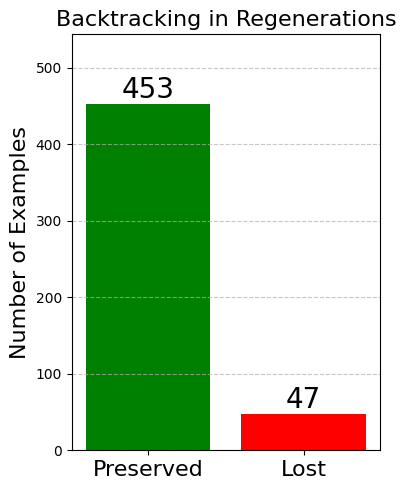

In [19]:
visualize_experiment_results({ 'deterministic_count': 453, 'total_examples': 500})

In [ ]:
def ablate_neurons_and_test(model, top_neurons, test_problems):
    """
    Ablate (zero out) the identified neurons and test the effect on backtracking.
    
    Args:
        model: The HookedTransformer model
        top_neurons: List of top neurons to ablate
        test_problems: List of test problems
        
    Returns:
        Dictionary with ablation results
    """
    # Define a hook function to ablate specific neurons
    def ablation_hook(activations, hook, neurons_to_ablate):
        # neurons_to_ablate is a list of (layer, neuron) tuples
        for layer, neuron in neurons_to_ablate:
            if hook.name == f"blocks.{layer}.hook_post":
                activations[0, :, neuron] = 0.0
        return activations
    
    # Prepare neurons to ablate
    neurons_to_ablate = [(n['layer'], n['neuron']) for n in top_neurons[:20]]  # Ablate top 20
    
    ablation_results = {
        'original': [],
        'ablated': []
    }
    
    for problem in tqdm(test_problems, desc="Testing ablation"):
        problem_text = problem['problem']
        
        # Generate solution without ablation
        original_prompt = f"Solve this math problem step by step. Put your final answer in \\boxed{{}}. Problem: {problem_text} Solution: \n<think>\n"
        original_solution = model.generate(original_prompt, 
                                         temperature=0.4,
                                         max_new_tokens=500,
                                         top_p=0.92)
        
        # Count backtracking instances in original
        original_backtracking = identify_backtracking(original_solution)
        
        # Generate solution with ablation
        ablated_solution = ""
        
        # Set up hooks for ablation
        hooks = []
        for layer in set(layer for layer, _ in neurons_to_ablate):
            hook_name = f"blocks.{layer}.hook_post"
            hook_fn = lambda act, hook=None, neurons=neurons_to_ablate: ablation_hook(act, hook, neurons)
            hooks.append((hook_name, hook_fn))
        
        # Generate with hooks
        with model.hooks(hooks):
            ablated_solution = model.generate(original_prompt, 
                                            temperature=0.4,
                                            max_new_tokens=500,
                                            top_p=0.92)
        
        # Count backtracking instances in ablated
        ablated_backtracking = identify_backtracking(ablated_solution)
        
        ablation_results['original'].append({
            'problem': problem_text,
            'solution': original_solution,
            'backtracking_count': len(original_backtracking),
            'backtracking_instances': original_backtracking
        })
        
        ablation_results['ablated'].append({
            'problem': problem_text,
            'solution': ablated_solution,
            'backtracking_count': len(ablated_backtracking),
            'backtracking_instances': ablated_backtracking
        })
    
    # Calculate summary statistics
    original_backtracking_count = sum(r['backtracking_count'] for r in ablation_results['original'])
    ablated_backtracking_count = sum(r['backtracking_count'] for r in ablation_results['ablated'])
    
    ablation_results['summary'] = {
        'original_backtracking_total': original_backtracking_count,
        'ablated_backtracking_total': ablated_backtracking_count,
        'percent_change': ((ablated_backtracking_count - original_backtracking_count) / 
                          max(1, original_backtracking_count)) * 100
    }
    
    return ablation_results